In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

c:\users\gustav.k.lundberg\appdata\local\continuum\anaconda3\envs\rpsenv_clone\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\gustav.k.lundberg\appdata\local\continuum\anaconda3\envs\rpsenv_clone\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\gustav.k.lundberg\appdata\local\continuum\anaconda3\envs\rpsenv_clone\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)ty

In [2]:
# Reading data into pandas df
path = 'C:/Users/gustav.k.lundberg/data_analysis/datasets/weather-dataset/weatherHistory.csv'
df = pd.read_csv(path)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000233B447D4A8>],
      dtype=object)

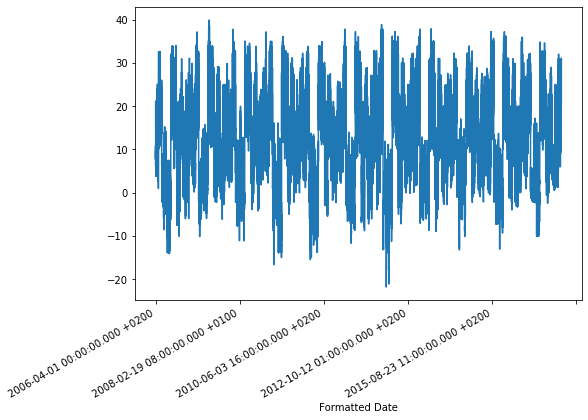

In [3]:
# Visualizing the dataset
dataset = df['Temperature (C)']
dataset.index = df['Formatted Date']

dataset.plot(subplots=True)

In [4]:
# Transforming dataset to np.array
dataset = dataset.values

In [5]:
### Standardize the dataset ###
dataset_mean = dataset.mean()
dataset_std = dataset.std()

dataset = (dataset-dataset_mean)/dataset_std

In [6]:
# This function takes the 'raw' dataset (probably in the form of a numpy array) and returns np.arrays x_train and y_train, or alternatively x_test and y_test
# dataset - a one-dimensional np.array (vector)
# start_index and end_index are used together to determine what part of the dataset dataset that we want to use
# history_size - the number of previous time-steps to use
# target_size - the number of steps in the future we want the model to predict
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    
    if end_index == None:
        end_index = len(dataset)-1
    
    features = []
    labels = []
    
    curr_index_start = start_index
    curr_index_end = start_index + history_size
    
    while curr_index_end <= end_index:
        features.append(dataset[curr_index_start:curr_index_end])
        labels.append(dataset[curr_index_end])
        curr_index_start += 1
        curr_index_end += 1
    
    return np.reshape(np.array(features), (-1, history_size, 1)), labels

In [7]:
num_examples_train = 70000
start_index = 0
history_size = 20 # Using the past 20 time-steps
target_size = 1 # Predicting the next time-step

x_train, y_train = univariate_data(dataset = dataset, 
                                   start_index = start_index, 
                                   end_index = start_index + num_examples_train, 
                                   history_size = history_size, 
                                   target_size = target_size)

x_test, y_test = univariate_data(dataset = dataset, 
                                 start_index = start_index + num_examples_train, 
                                 end_index = None, 
                                 history_size = history_size, 
                                 target_size = target_size)

In [8]:
# Inspecting the dataset
#print('x_train = ', x_train[0])
#print('y_train = ', y_train[0])
#print('x_test = ', x_test[0])
#print('y_test = ', y_test[0])

#print('x_train = ', x_train.shape)
#print('y_train = ', len(y_train))
#print('x_test = ', x_test.shape)
#print('y_test = ', len(y_test))

In [9]:
# Plotting an example and its label

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'c:\\users\\gustav.k.lundberg\\appdata\\local\\continuum\\anaconda3\\envs\\rpsenv_clone\\lib\\site-packages\\matplotlib\\pyplot.py'>

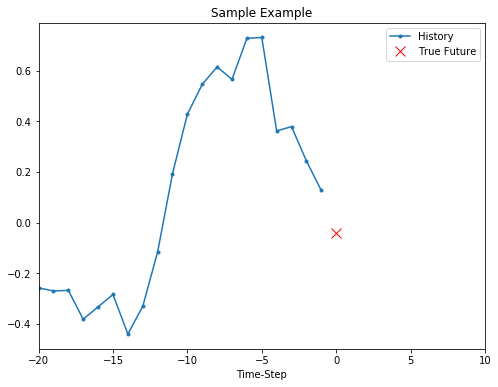

In [10]:
show_plot(plot_data = [x_train[0], y_train[0]], delta = 0, title = 'Sample Example')

In [11]:
model = Sequential()
model.add(LSTM(units = 3, input_shape = (x_train.shape[1], 1), activation = 'relu', return_sequences = False))
model.add(Dense(units = 1, activation = 'linear'))

opt = Adam(lr = 0.005, decay = 1e-5)

model.compile(optimizer = opt, loss = 'mse')#, metrics = ['mse'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [12]:
### Train the model ###
batch_size = 32
num_epochs = 25

#NAME = f"{history_size}-SEQ-{target_size}-PRED-{int(time.time())}"
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

#filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones


history = model.fit(x = x_train, 
                    y = y_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    validation_data = (x_test, y_test))
                    #callbacks = [tensorboard, checkpoint])

Train on 9981 samples, validate on 86433 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
9981/9981 [==============================] - 20s 2ms/sample - loss: 0.3364 - val_loss: 0.1281
Epoch 2/25
9981/9981 [==============================] - 17s 2ms/sample - loss: 0.0827 - val_loss: 0.0597
Epoch 3/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0474 - val_loss: 0.0392
Epoch 4/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0359 - val_loss: 0.0321
Epoch 5/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0315 - val_loss: 0.0286
Epoch 6/25
9981/9981 [==============================] - 16s 2ms/sample - loss: 0.0291 - val_loss: 0.0275
Epoch 7/25
9981/9981 [==============================] - 16s 2ms/sample - loss: 0.0279 - val_loss: 0.0260
Epoch 8/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0273 - val_loss: 0.0250
Epoch 9/25
9981/9981 [==============================] - 16s 2ms

<Figure size 576x432 with 0 Axes>

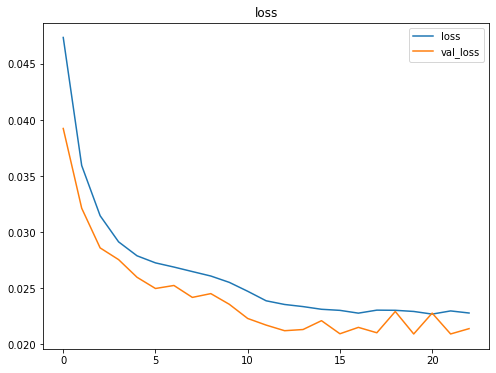

<Figure size 576x432 with 0 Axes>

In [13]:
### Plotting the training loss ###
#print(history.history.keys())
remove_initial = 2
loss = history.history['loss']
val_loss = history.history['val_loss']
if remove_initial:
    loss = loss[remove_initial:]
    val_loss = val_loss[remove_initial:]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.figure()

random_example_index =  1949
random_example_index =  4413
random_example_index =  857
random_example_index =  9019
random_example_index =  5033
random_example_index =  3860
random_example_index =  4656
random_example_index =  1544
random_example_index =  5025
random_example_index =  2004
random_example_index =  7138
random_example_index =  971
random_example_index =  940
random_example_index =  7568
random_example_index =  6134
random_example_index =  3260


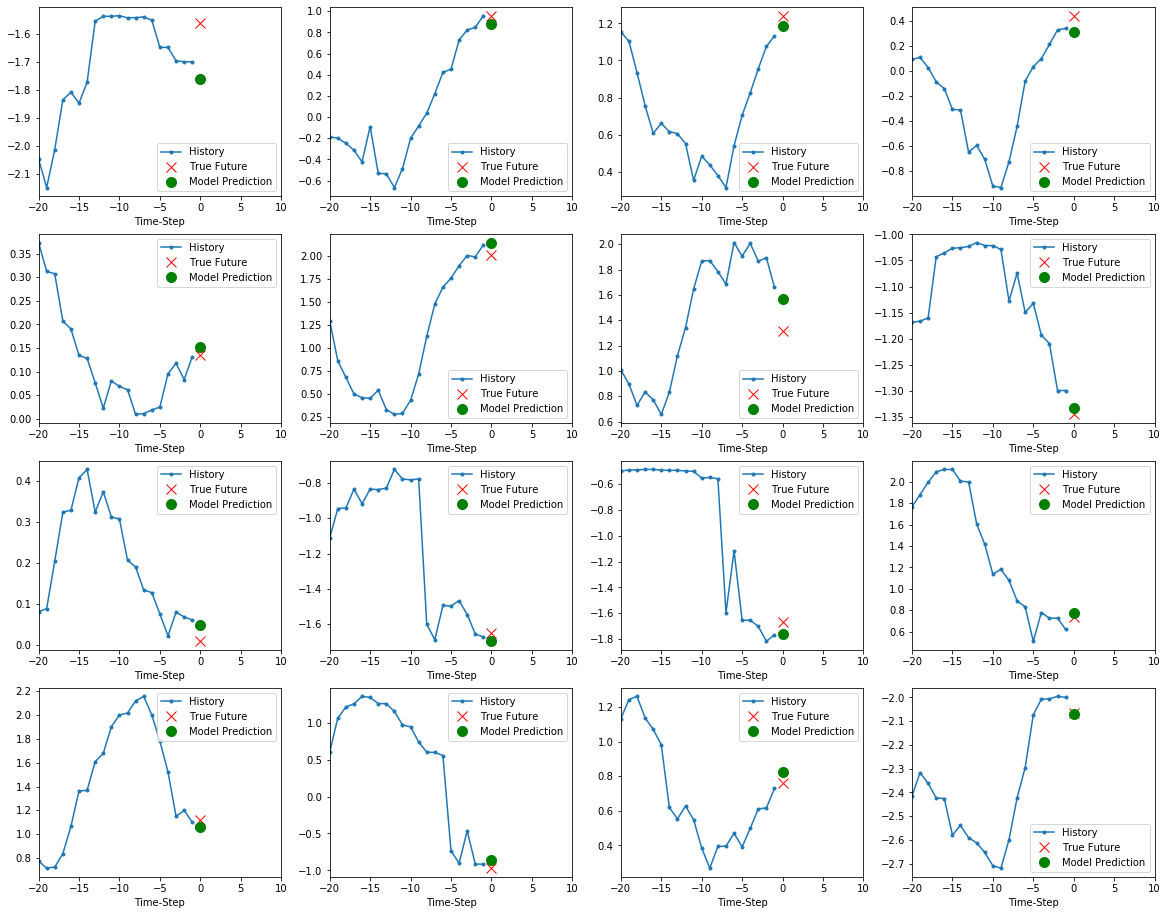

In [108]:
### Plotting a few training examples ###
nrows = 4
ncols = 4

mpl.rcParams['figure.figsize'] = (20, 16)

pos = 1
for col in range(ncols):
    for row in range(nrows):
        ax = plt.subplot(nrows, ncols, pos)
        random_example_index = random.randint(0, x_train.shape[0] - history_size)
        print('random_example_index = ', random_example_index)
        pred = model.predict(x_train[random_example_index:random_example_index+1])
        show_plot(plot_data = [x_train[random_example_index], y_train[random_example_index], pred], delta = 0, title = '')
        pos += 1

In [15]:
model2 = Sequential()
model2.add(LSTM(units = 16, input_shape = (x_train.shape[1], 1), activation = 'relu', return_sequences = False))
model2.add(Dense(units = 8, activation = 'sigmoid'))
model2.add(Dense(units = 1, activation = 'linear'))

opt = Adam(lr = 0.005, decay = 1e-5)

model2.compile(optimizer = opt, loss = 'mse')#, metrics = ['mse'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [16]:
### Train the model ###
batch_size = 32
num_epochs = 25

#NAME = f"{history_size}-SEQ-{target_size}-PRED-{int(time.time())}"
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

#filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones


history2 = model2.fit(x = x_train, 
                    y = y_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    validation_data = (x_test, y_test))
                    #callbacks = [tensorboard, checkpoint])

Train on 9981 samples, validate on 86433 samples
Epoch 1/25
9981/9981 [==============================] - 20s 2ms/sample - loss: 0.1425 - val_loss: 0.0294
Epoch 2/25
9981/9981 [==============================] - 21s 2ms/sample - loss: 0.0284 - val_loss: 0.0256
Epoch 3/25
9981/9981 [==============================] - 21s 2ms/sample - loss: 0.0247 - val_loss: 0.0230
Epoch 4/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0245 - val_loss: 0.0212
Epoch 5/25
9981/9981 [==============================] - 17s 2ms/sample - loss: 0.0236 - val_loss: 0.0209
Epoch 6/25
9981/9981 [==============================] - 19s 2ms/sample - loss: 0.0223 - val_loss: 0.0204
Epoch 7/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0224 - val_loss: 0.0218
Epoch 8/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0219 - val_loss: 0.0207
Epoch 9/25
9981/9981 [==============================] - 18s 2ms/sample - loss: 0.0220 - val_loss: 0.0198
Epoch 

<Figure size 1440x1152 with 0 Axes>

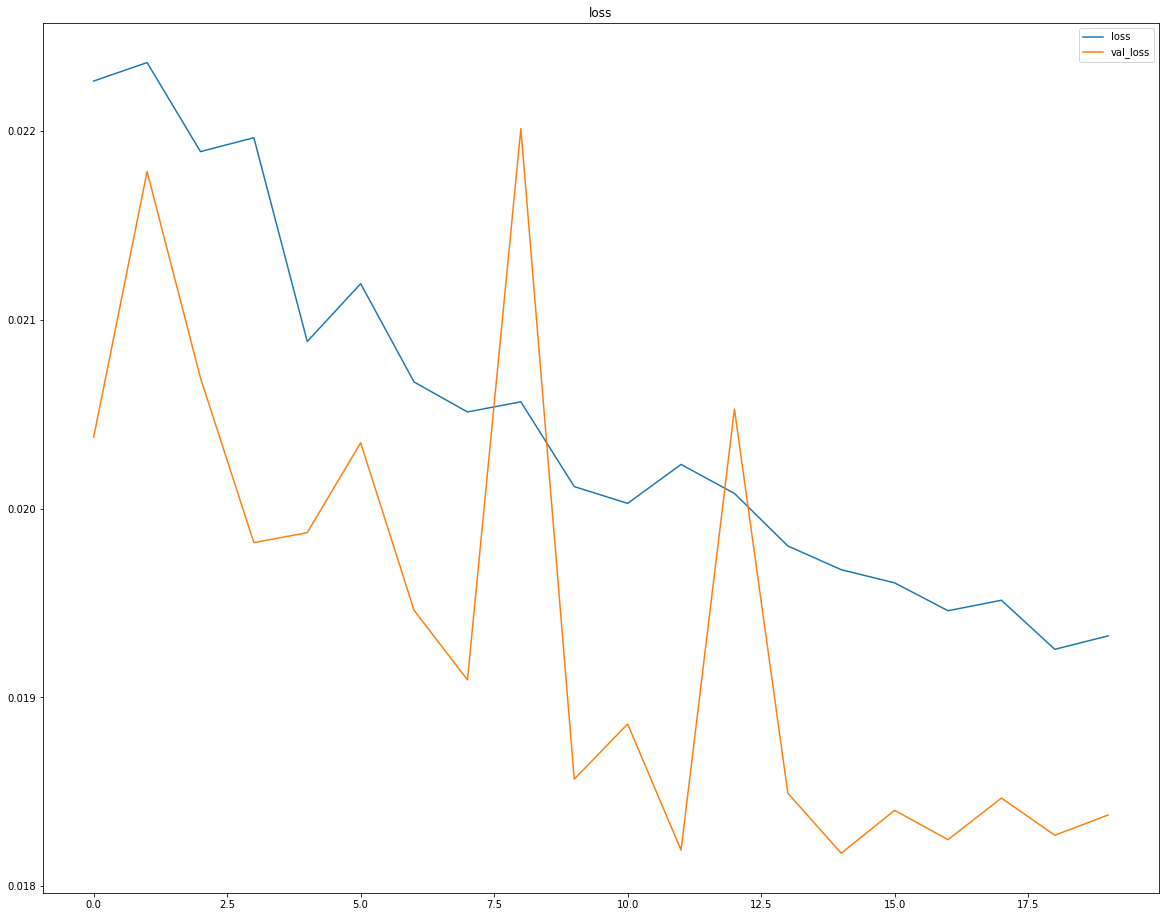

<Figure size 1440x1152 with 0 Axes>

In [17]:
### Plotting the training loss ###
#print(history.history.keys())
remove_initial = 5
loss = history2.history['loss']
val_loss = history2.history['val_loss']
if remove_initial:
    loss = loss[remove_initial:]
    val_loss = val_loss[remove_initial:]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.figure()

random_example_index =  8898
random_example_index =  7422
random_example_index =  3063
random_example_index =  7724
random_example_index =  7338
random_example_index =  3675
random_example_index =  4684
random_example_index =  7708
random_example_index =  525
random_example_index =  5330
random_example_index =  2522
random_example_index =  9747
random_example_index =  2869
random_example_index =  258
random_example_index =  5789
random_example_index =  7795


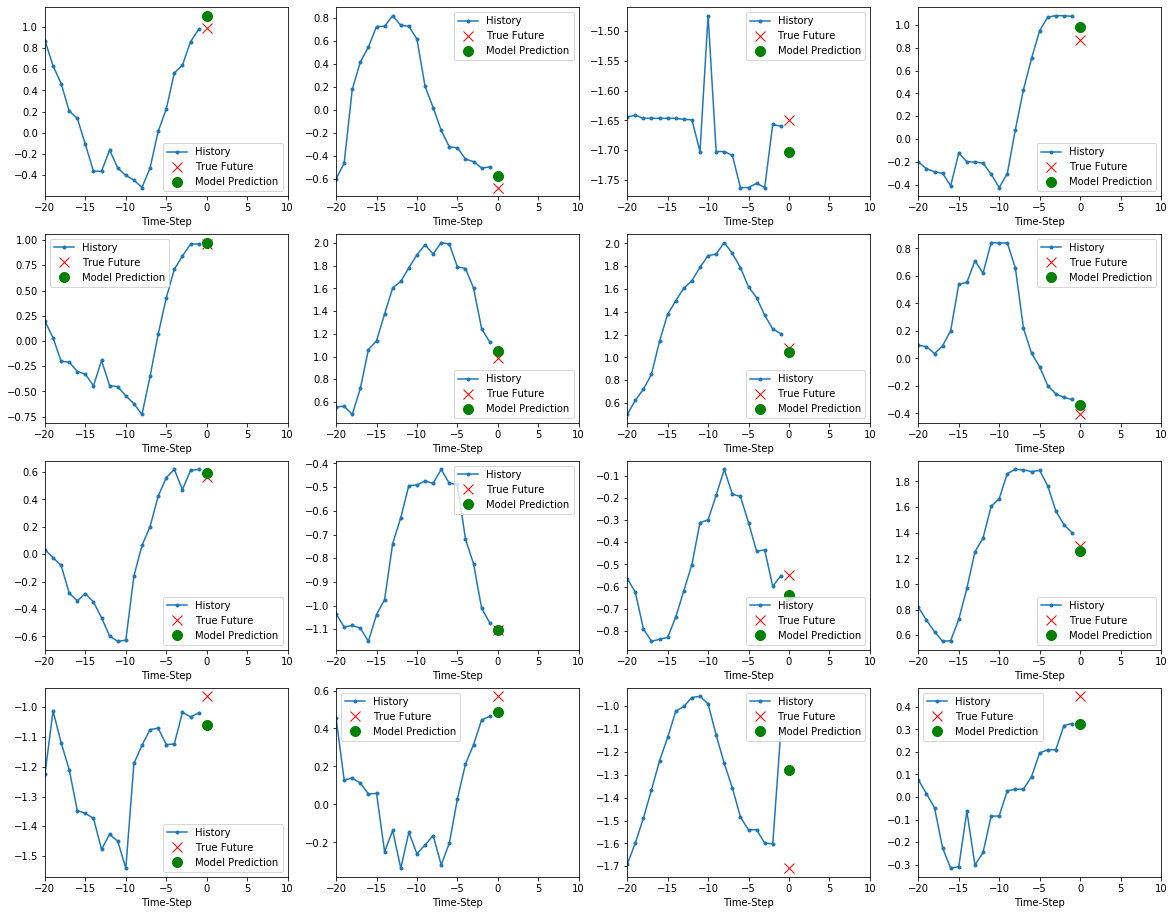

In [18]:
### Plotting a few training examples ###
nrows = 4
ncols = 4

mpl.rcParams['figure.figsize'] = (20, 16)

pos = 1
for col in range(ncols):
    for row in range(nrows):
        ax = plt.subplot(nrows, ncols, pos)
        random_example_index = random.randint(0, x_train.shape[0] - history_size)
        print('random_example_index = ', random_example_index)
        pred = model2.predict(x_train[random_example_index:random_example_index+1])
        show_plot(plot_data = [x_train[random_example_index], y_train[random_example_index], pred], delta = 0, title = '')
        pos += 1

random_example_index =  8232
random_example_index =  33310
random_example_index =  32179
random_example_index =  71557
random_example_index =  72782
random_example_index =  6584
random_example_index =  55599
random_example_index =  21333
random_example_index =  60544
random_example_index =  42883
random_example_index =  51567
random_example_index =  72669
random_example_index =  18463
random_example_index =  77447
random_example_index =  55318
random_example_index =  31469


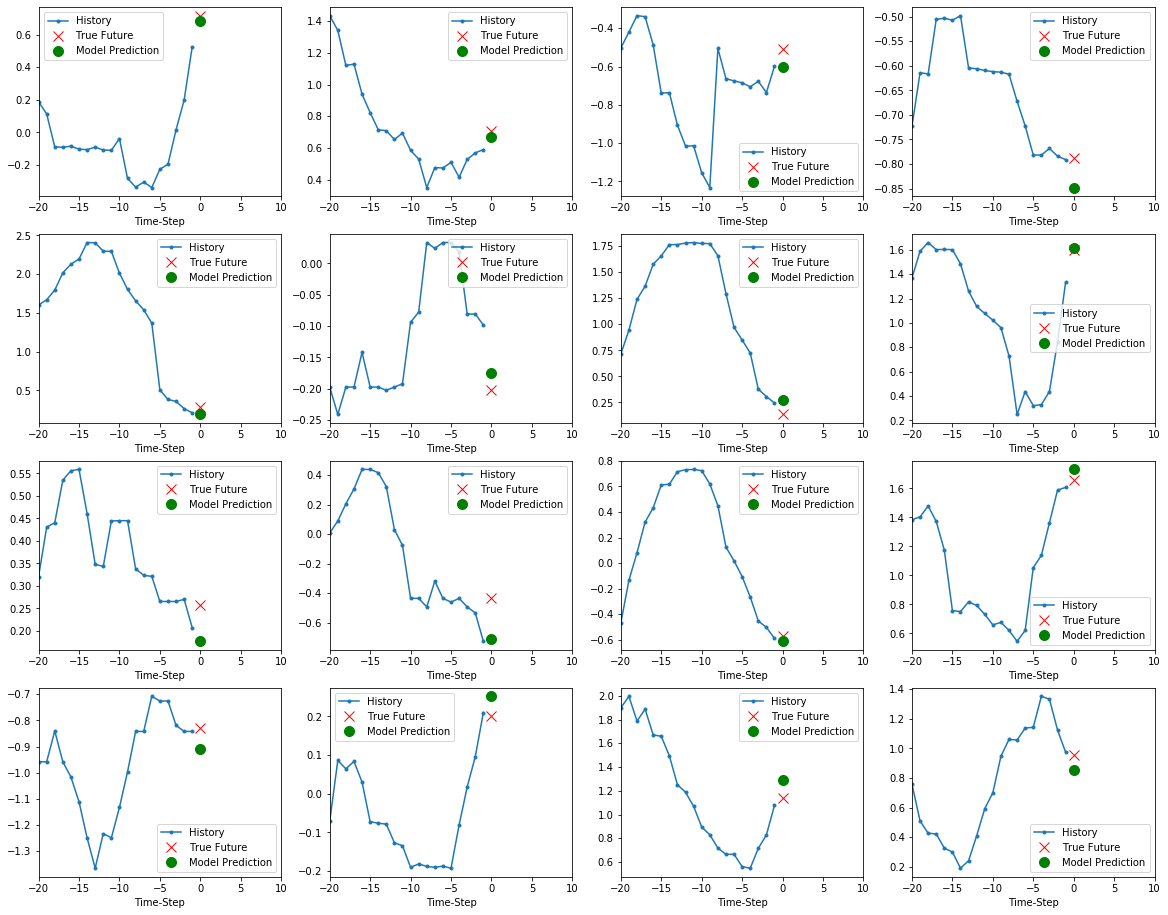

In [19]:
### Plotting a few test examples ###
nrows = 4
ncols = 4

mpl.rcParams['figure.figsize'] = (20, 16)

pos = 1
for col in range(ncols):
    for row in range(nrows):
        ax = plt.subplot(nrows, ncols, pos)
        random_example_index = random.randint(0, x_test.shape[0] - history_size)
        print('random_example_index = ', random_example_index)
        pred = model2.predict(x_test[random_example_index:random_example_index+1])
        show_plot(plot_data = [x_test[random_example_index], y_test[random_example_index], pred], delta = 0, title = '')
        pos += 1

<h3>Multivariate data, predicting multiple time-steps in the future</h3>

In [12]:
# This function takes the 'raw' dataset (probably in the form of a numpy array) and returns np.arrays x_train and y_train, or alternatively x_test and y_test
# dataset - a np.array
# start_index and end_index are used together to determine what part of the dataset dataset that we want to use
# history_steps - the number of previous time-steps to use
# future_steps - the number of steps in the future we want the model to predict (1 being predict one step in the future, 2 being predicting one AND two steps in the future etc)
def multivariate_data(dataset, start_index, end_index, history_steps, future_steps):
    
    if end_index == None:
        end_index = dataset.shape[0]-1
    
    features = []
    labels = []
    
    curr_feat_ind_start = start_index
    curr_feat_ind_end = start_index + history_steps
    curr_lab_ind_start = curr_feat_ind_end
    curr_lab_ind_end = curr_lab_ind_start + future_steps
    
    while curr_feat_ind_end <= end_index and curr_lab_ind_end < dataset.shape[0]:
        features.append(dataset[curr_feat_ind_start:curr_feat_ind_end, :])
        labels.append(dataset[curr_lab_ind_start:curr_lab_ind_end, 0]) # NOTE THE 0 HERE - the first column is the one we use as target variable.
        curr_feat_ind_start += 1
        curr_feat_ind_end += 1
        curr_lab_ind_start += 1
        curr_lab_ind_end += 1
        
    return np.array(features), np.array(labels)
#    return np.reshape(np.array(features), (-1, history_steps, dataset.shape[1])), np.reshape(np.array(labels), (future_steps, 1))

In [13]:
dataset_mv = df[['Temperature (C)', 'Humidity', 'Pressure (millibars)', 'Wind Speed (km/h)']]
dataset_mv = np.array(dataset_mv)
print(dataset_mv.shape)

(96453, 4)


In [14]:
### Standardizing the dataset ###
mean_mv = np.mean(dataset_mv, axis = 0)
std_mv = np.std(dataset_mv, axis = 0)
dataset_mv = (dataset_mv - mean_mv) / std_mv
print(dataset_mv.shape)
print(dataset_mv[:10])

(96453, 4)
[[-0.25759902  0.79347043  0.10168518  0.47863499]
 [-0.26981351  0.63999555  0.1059598   0.49959388]
 [-0.26748694  0.79347043  0.10861007 -0.99547337]
 [-0.38148885  0.48652066  0.11262822  0.47630623]
 [-0.33263089  0.48652066  0.11348315  0.03384084]
 [-0.28377293  0.58883725  0.11476553  0.45534734]
 [-0.43965309  1.10042019  0.11527849  0.22479959]
 [-0.33088596  0.79347043  0.1163044   0.48329252]
 [-0.11625992  0.43536237  0.1208355   0.07342985]
 [ 0.1925922  -0.07622057  0.11955312  0.24808724]]


In [15]:
num_examples_train = 70000
start_index = 0
history_steps = 100 # Using the past 20 time-steps
future_steps = 20 # Predicting the next time-step

x_train_mv, y_train_mv = multivariate_data(dataset = dataset_mv, 
                                           start_index = 0,
                                           end_index = num_examples_train, 
                                           history_steps = history_steps, 
                                           future_steps = future_steps)

x_test_mv, y_test_mv = multivariate_data(dataset = dataset_mv, 
                                         start_index = start_index + num_examples_train,
                                         end_index = None, 
                                         history_steps = history_steps, 
                                         future_steps = future_steps)

In [16]:
### Check out the first example and its label ###
print('x = \n', x_train_mv[0])
print('y = ', y_train_mv[0])
print('x = \n', x_test_mv[0])
print('y = ', y_test_mv[0])

x = 
 [[-2.57599020e-01  7.93470427e-01  1.01685179e-01  4.78634993e-01]
 [-2.69813510e-01  6.39995545e-01  1.05959805e-01  4.99593880e-01]
 [-2.67486941e-01  7.93470427e-01  1.08610073e-01 -9.95473368e-01]
 [-3.81488852e-01  4.86520663e-01  1.12628221e-01  4.76306228e-01]
 [-3.32630890e-01  4.86520663e-01  1.13483147e-01  3.38408431e-02]
 [-2.83772928e-01  5.88837251e-01  1.14765534e-01  4.55347341e-01]
 [-4.39653092e-01  1.10042019e+00  1.15278490e-01  2.24799588e-01]
 [-3.30885963e-01  7.93470427e-01  1.16304400e-01  4.83292523e-01]
 [-1.16259916e-01  4.35362369e-01  1.20835503e-01  7.34298512e-02]
 [ 1.92592200e-01 -7.62205699e-02  1.19553115e-01  2.48087240e-01]
 [ 4.27575731e-01 -3.32012040e-01  1.21262966e-01  9.76990742e-01]
 [ 5.45649139e-01 -9.97069861e-01  1.23998726e-01  1.29836034e+00]
 [ 6.14282942e-01 -9.45911567e-01  1.22716339e-01  1.61041487e+00]
 [ 5.65424981e-01 -1.15054474e+00  1.21775921e-01  1.42877119e+00]
 [ 7.27121569e-01 -1.35517792e+00  1.19125653e-01  6.602

In [17]:
def multi_step_plot(history, true_future, prediction):
  STEP = 1
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  return plt

random_example_index =  59718


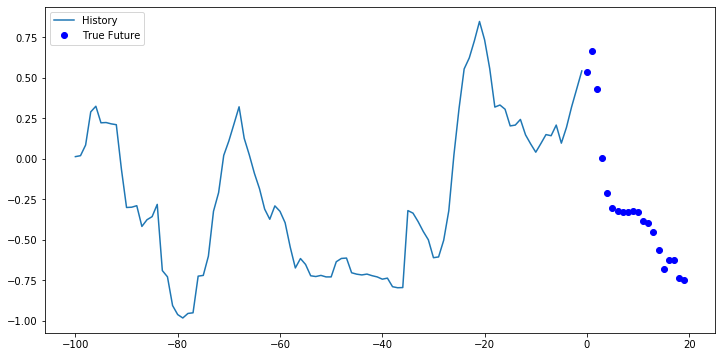

random_example_index =  54049


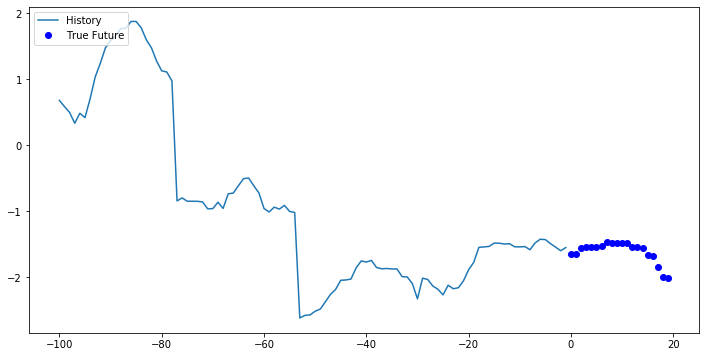

random_example_index =  18169


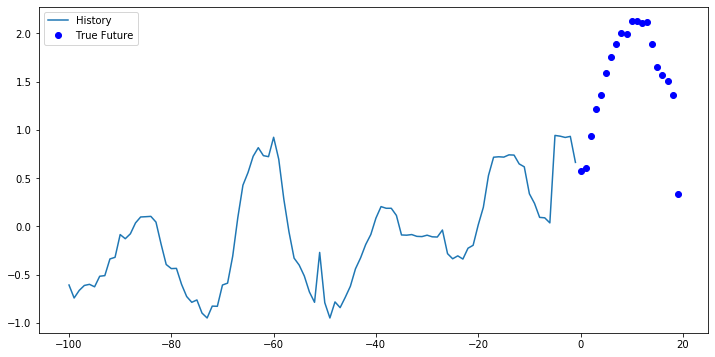

random_example_index =  46193


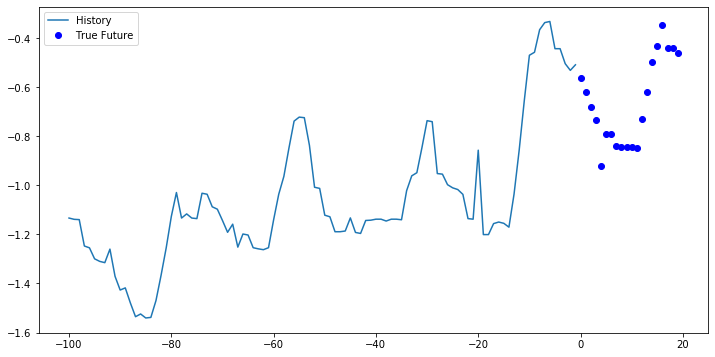

In [18]:
### Plotting a few training examples ###
mpl.rcParams['figure.figsize'] = (12, 8)

num_plots = 4
for i in range(num_plots):
    random_example_index = random.randint(0, x_train.shape[0] - history_steps - future_steps)
    print('random_example_index = ', random_example_index)
    multi_step_plot(history = x_train_mv[random_example_index], 
                    true_future = y_train_mv[random_example_index], 
                    prediction = np.array([]))

In [89]:
### Building the model ###
model_mv = Sequential()
model_mv.add(LSTM(units = 32, input_shape = (x_train_mv.shape[1:]), activation = 'relu', return_sequences = True))
model_mv.add(LSTM(units = 16, activation = 'relu', return_sequences = False))
model_mv.add(Dense(units = future_steps, activation = 'linear'))

opt = Adam(lr = 0.005, decay = 1e-5)
model_mv.compile(optimizer = opt, loss = 'mae')
model_mv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 32)           4736      
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                340       
Total params: 8,212
Trainable params: 8,212
Non-trainable params: 0
_________________________________________________________________


In [90]:
### Train the model ###
batch_size = 32
num_epochs = 5

history_mv = model_mv.fit(x = x_train_mv, 
                          y = y_train_mv,
                          epochs = num_epochs,
                          batch_size = batch_size,
                          validation_data = (x_test_mv, y_test_mv))

Train on 69901 samples, validate on 26333 samples
Epoch 1/5
69901/69901 [==============================] - 408s 6ms/sample - loss: 0.2920 - val_loss: 0.2253
Epoch 2/5
69901/69901 [==============================] - 388s 6ms/sample - loss: 0.2418 - val_loss: 0.2230
Epoch 3/5
69901/69901 [==============================] - 403s 6ms/sample - loss: 0.2403 - val_loss: 0.2225
Epoch 4/5
69901/69901 [==============================] - 407s 6ms/sample - loss: 0.2294 - val_loss: 0.2169
Epoch 5/5
69901/69901 [==============================] - 407s 6ms/sample - loss: 0.2224 - val_loss: 0.2166


<Figure size 864x576 with 0 Axes>

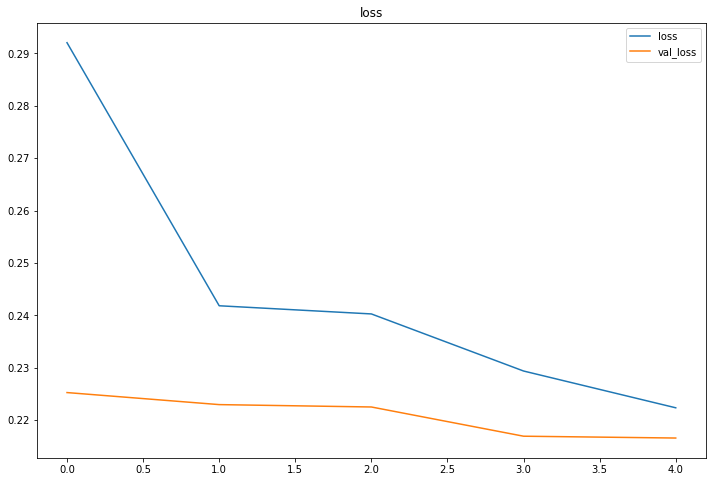

<Figure size 864x576 with 0 Axes>

In [91]:
### Plotting the training loss ###
#print(history.history.keys())
remove_initial = 0
loss = history_mv.history['loss']
val_loss = history_mv.history['val_loss']
if remove_initial:
    loss = loss[remove_initial:]
    val_loss = val_loss[remove_initial:]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.figure()

random_example_index =  50269


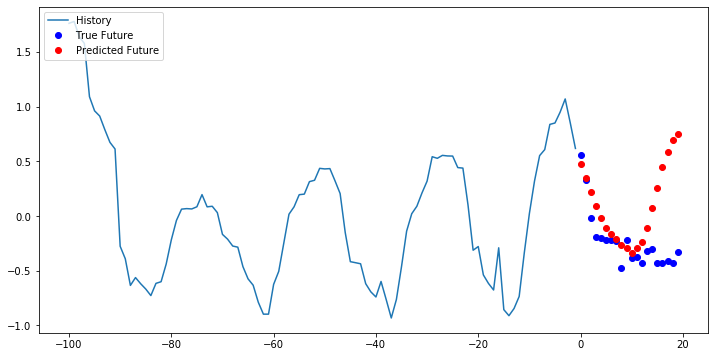

random_example_index =  43769


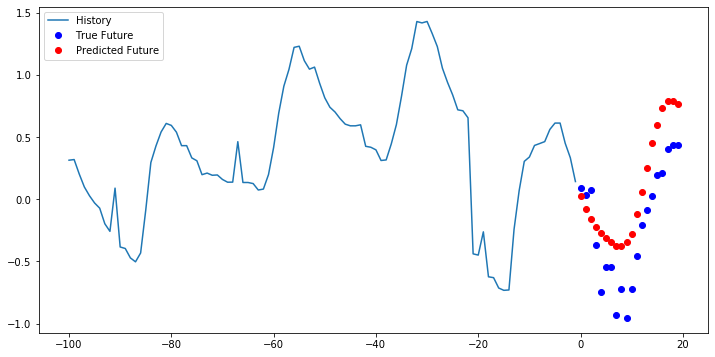

random_example_index =  10761


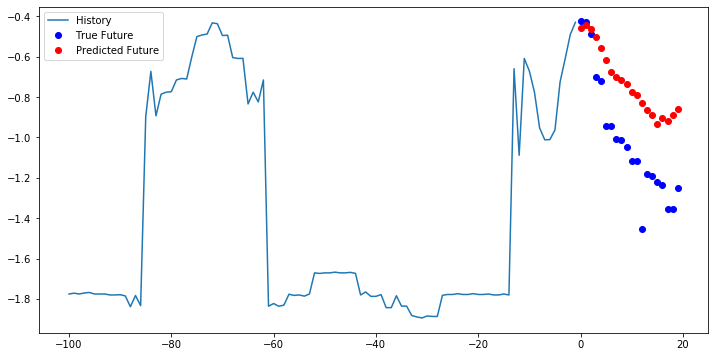

random_example_index =  22268


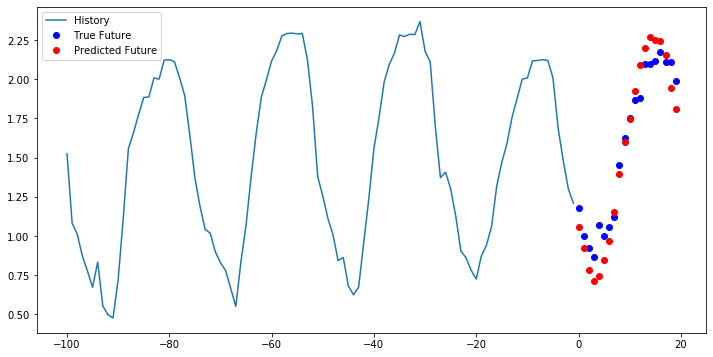

In [92]:
### Trying to predict with the untrained model to make sure everything looks good (wr dimensions etc) ###
#print(x_train_mv[0])

mpl.rcParams['figure.figsize'] = (12, 8)

num_plots = 4
for i in range(num_plots):
    random_example_index = random.randint(0, x_train.shape[0] - history_steps - future_steps)
    print('random_example_index = ', random_example_index)
    pred = model_mv.predict(x_train_mv[random_example_index:random_example_index+1])
    pred = np.reshape(pred, (future_steps))
    
    #pred2 = y_train_mv[random_example_index]+1
    
    multi_step_plot(history = x_train_mv[random_example_index], 
                    true_future = y_train_mv[random_example_index], 
                    prediction = pred)

In [123]:
### Building the model ###
model_mv2 = Sequential()
model_mv2.add(LSTM(units = 64, input_shape = (x_train_mv.shape[1:]), activation = 'relu', return_sequences = True))
model_mv2.add(LSTM(units = 32, activation = 'relu', return_sequences = True))
model_mv2.add(LSTM(units = 16, activation = 'relu', return_sequences = False))
model_mv2.add(Dense(units = future_steps, activation = 'linear'))

opt = Adam(lr = 0.001, decay = 1e-5)
model_mv2.compile(optimizer = opt, loss = 'mae')
model_mv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 100, 64)           17664     
_________________________________________________________________
lstm_43 (LSTM)               (None, 100, 32)           12416     
_________________________________________________________________
lstm_44 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_14 (Dense)             (None, 20)                340       
Total params: 33,556
Trainable params: 33,556
Non-trainable params: 0
_________________________________________________________________


In [140]:
### Train the model ###
batch_size = 32
num_epochs = 5

history_mv2 = model_mv2.fit(x = x_train_mv, 
                          y = y_train_mv,
                          epochs = num_epochs,
                          batch_size = batch_size,
                          validation_data = (x_test_mv, y_test_mv))

Train on 69901 samples, validate on 26333 samples
Epoch 1/5


ValueError: Operation 'VarIsInitializedOp_881' has been marked as not fetchable.

<Figure size 864x576 with 0 Axes>

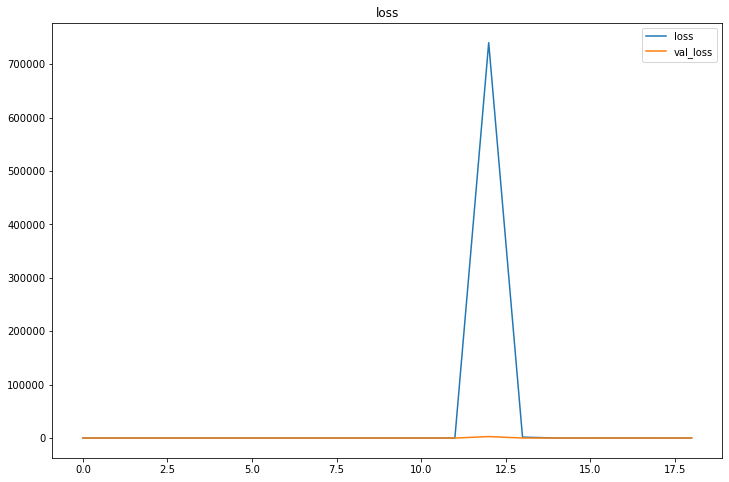

<Figure size 864x576 with 0 Axes>

In [120]:
### Plotting the training loss ###
#print(history.history.keys())
remove_initial = 1
loss_mv2 = history_mv2.history['loss']
val_loss_mv2 = history_mv2.history['val_loss']
if remove_initial:
    loss_mv2 = loss_mv2[remove_initial:]
    val_loss_mv2 = val_loss_mv2[remove_initial:]
plt.plot(loss_mv2)
plt.plot(val_loss_mv2)
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.figure()

random_example_index =  25761


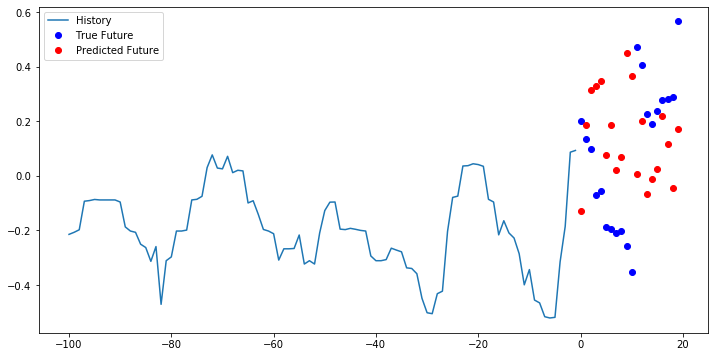

random_example_index =  22519


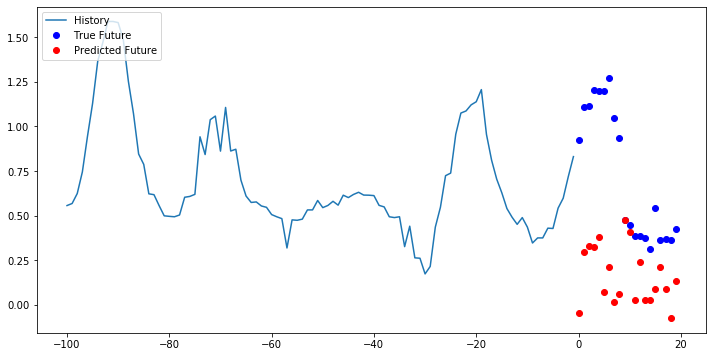

random_example_index =  39146


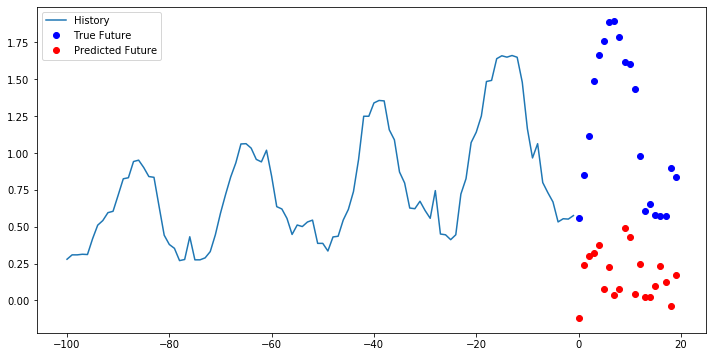

random_example_index =  43738


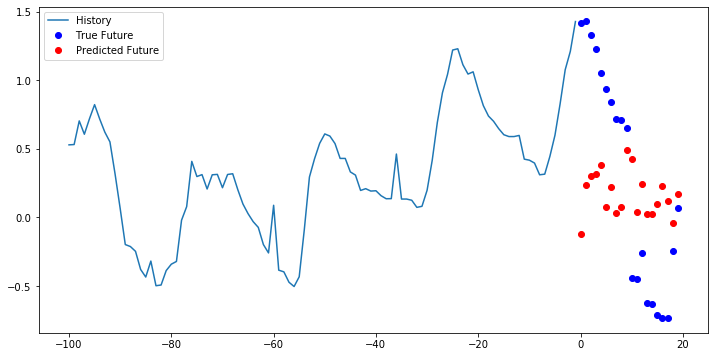

random_example_index =  335


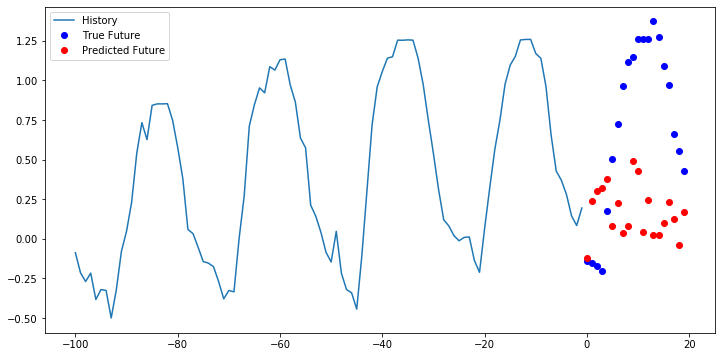

random_example_index =  44712


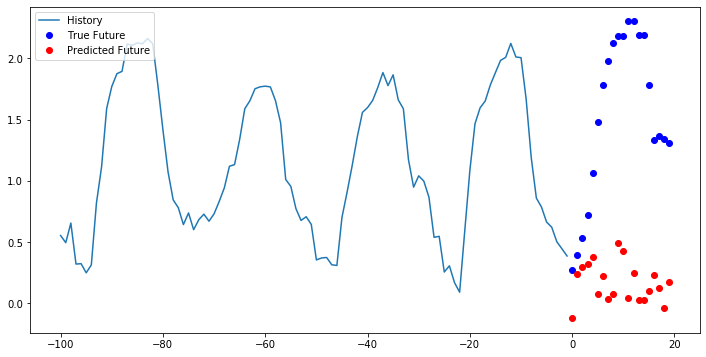

random_example_index =  361


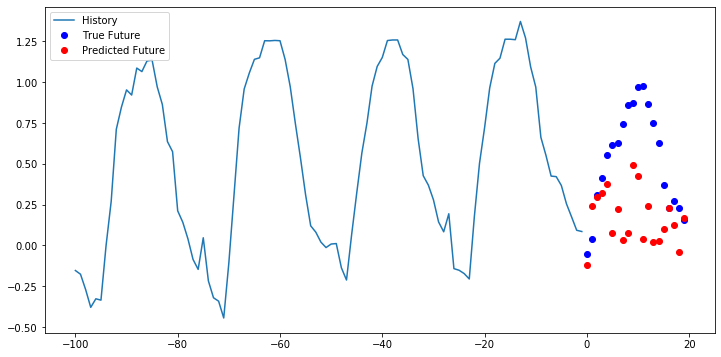

random_example_index =  18261


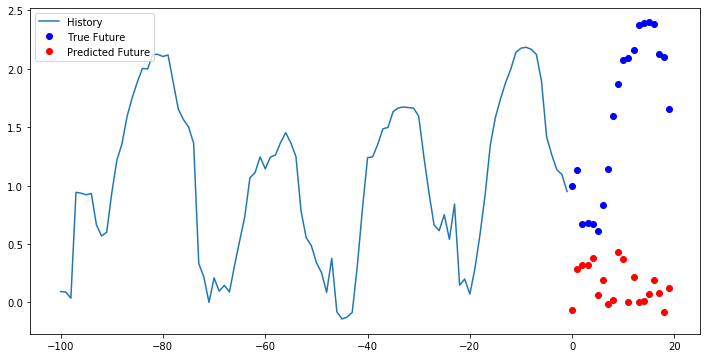

random_example_index =  40480


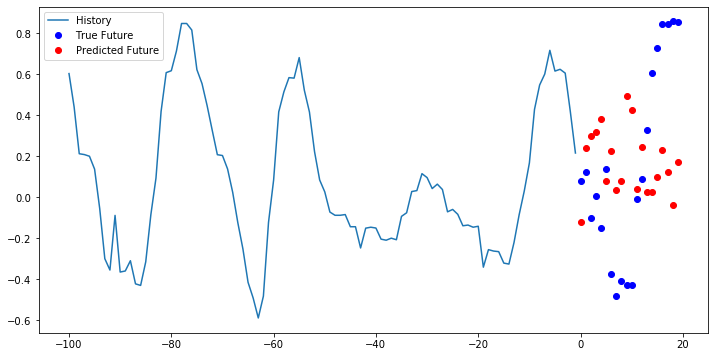

random_example_index =  29013


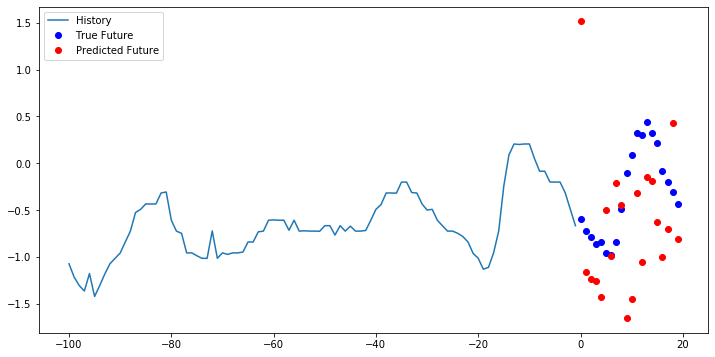

random_example_index =  20098


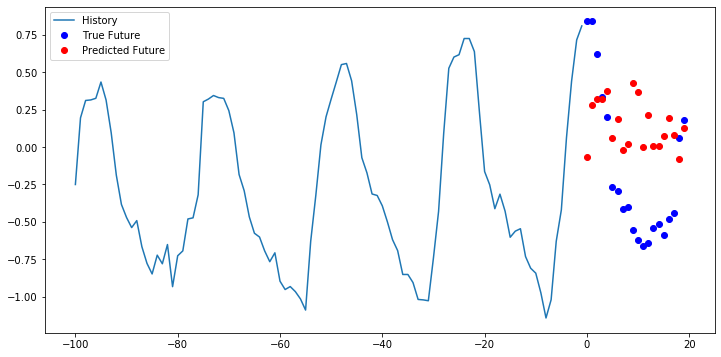

random_example_index =  40364


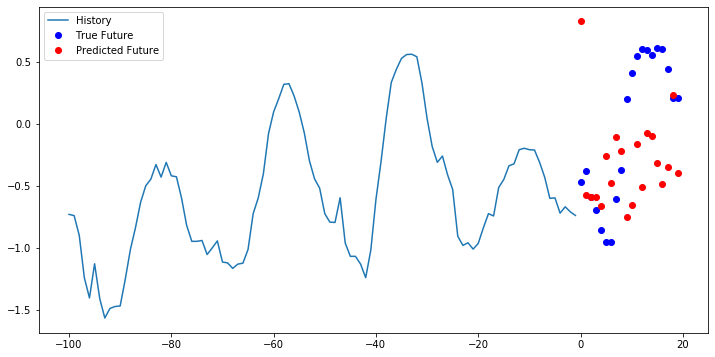

random_example_index =  23701


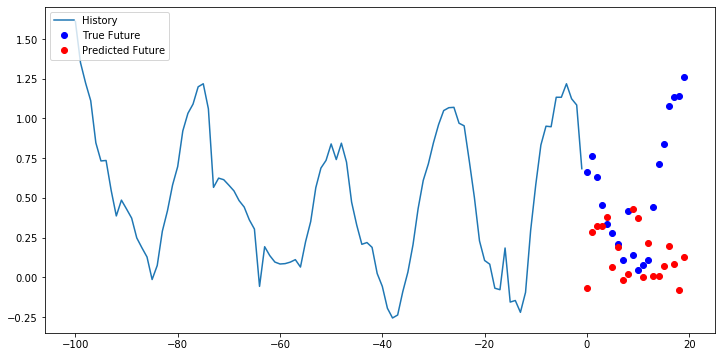

random_example_index =  41081


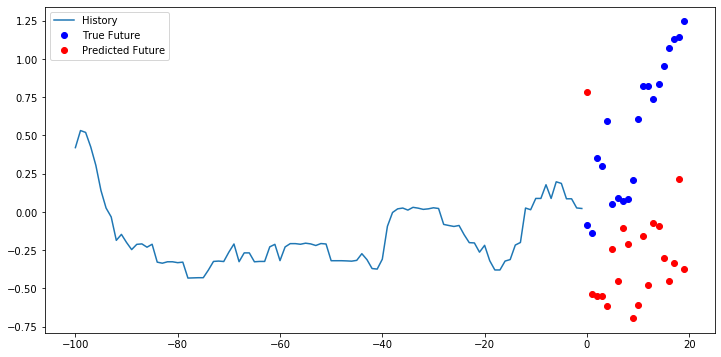

random_example_index =  58918


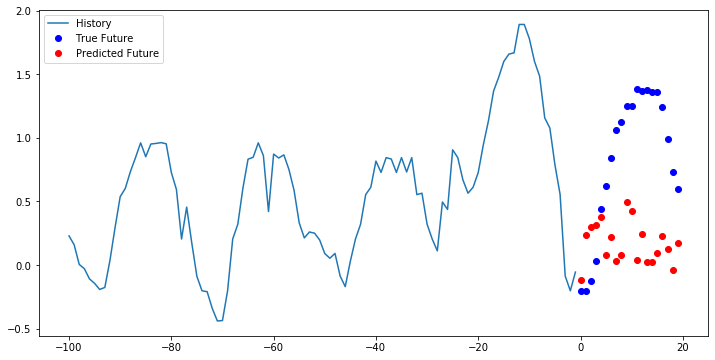

random_example_index =  55495


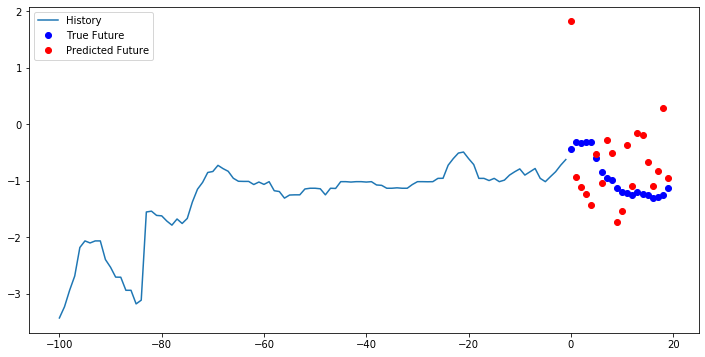

random_example_index =  4317


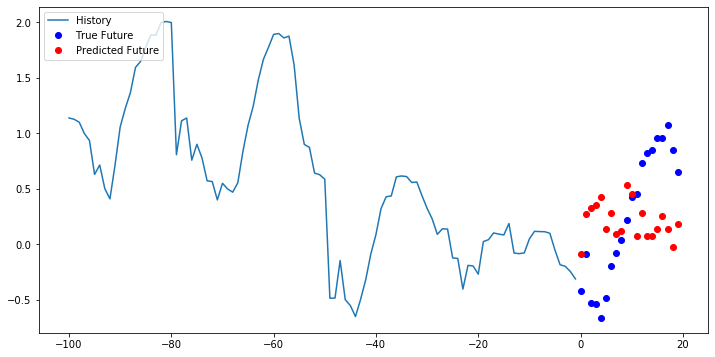

random_example_index =  41594


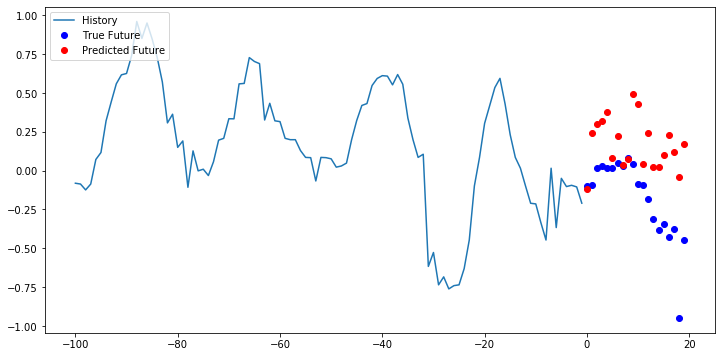

random_example_index =  41280


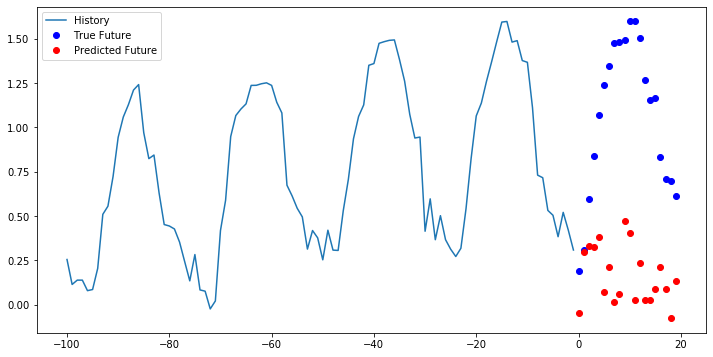

random_example_index =  64321


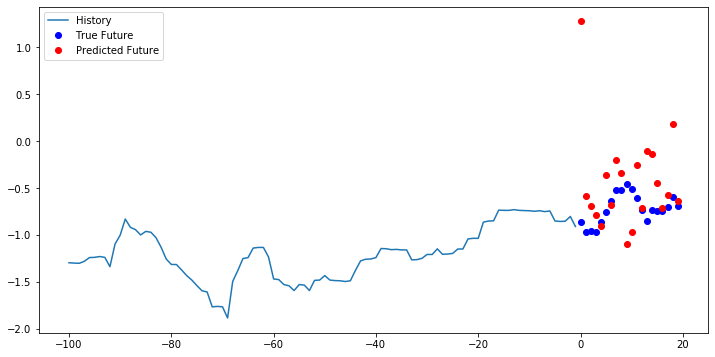

In [121]:
### Making some predictions on the training data ###

mpl.rcParams['figure.figsize'] = (12, 8)

num_plots = 20
for i in range(num_plots):
    random_example_index = random.randint(0, x_train_mv.shape[0] - history_steps - future_steps)
    print('random_example_index = ', random_example_index)
    pred = model_mv2.predict(x_train_mv[random_example_index:random_example_index+1])
    pred = np.reshape(pred, (future_steps))
    
    #pred2 = y_train_mv[random_example_index]+1
    
    multi_step_plot(history = x_train_mv[random_example_index], 
                    true_future = y_train_mv[random_example_index], 
                    prediction = pred)

random_example_index =  16827


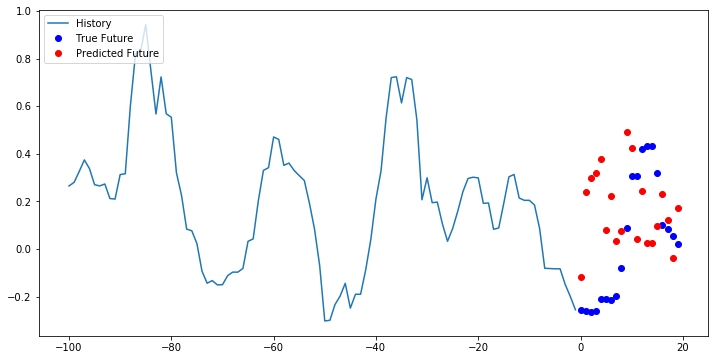

random_example_index =  22725


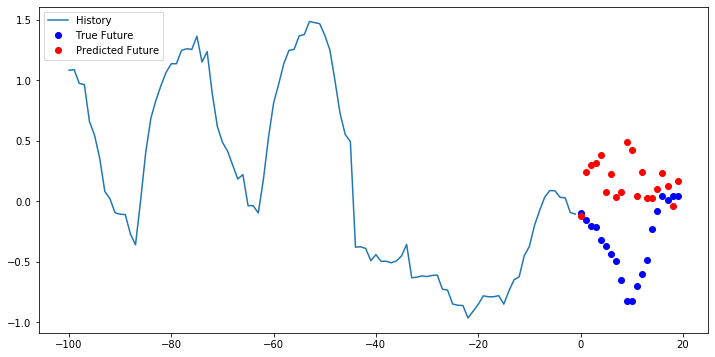

random_example_index =  13135


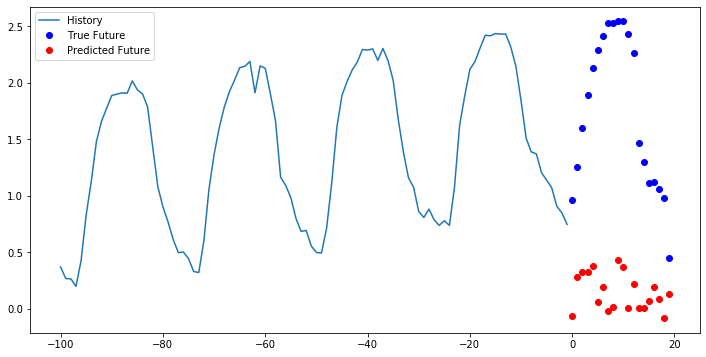

random_example_index =  4551


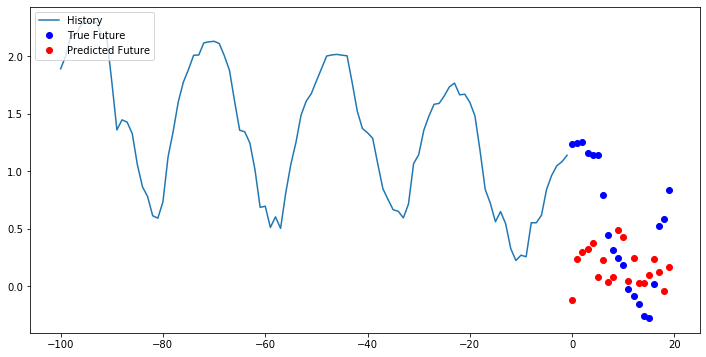

random_example_index =  4504


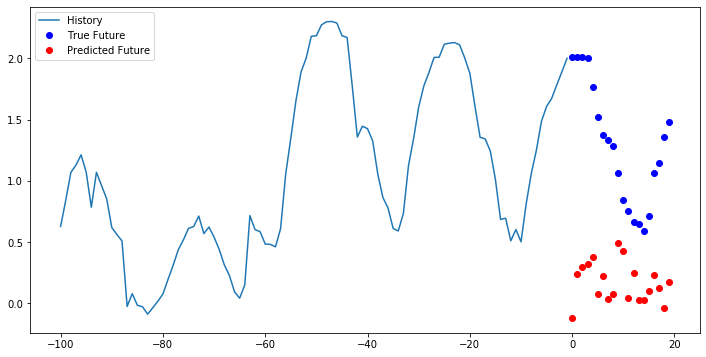

random_example_index =  12778


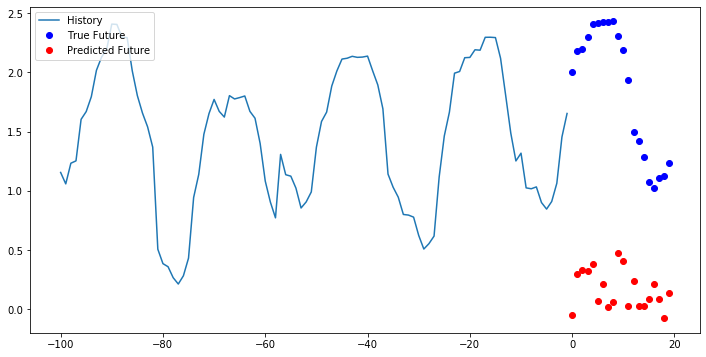

random_example_index =  10008


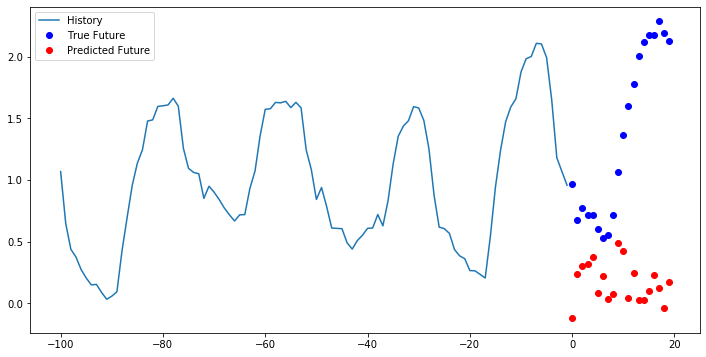

random_example_index =  8274


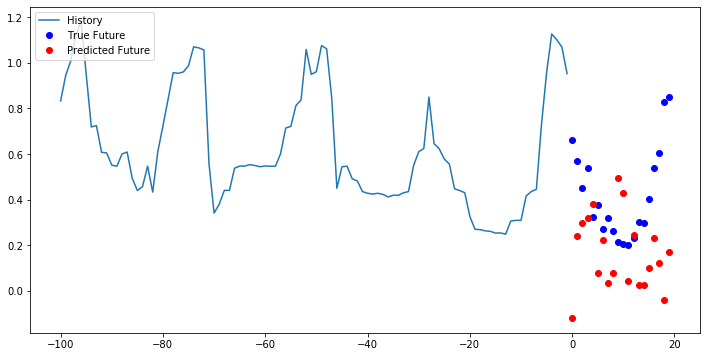

random_example_index =  4075


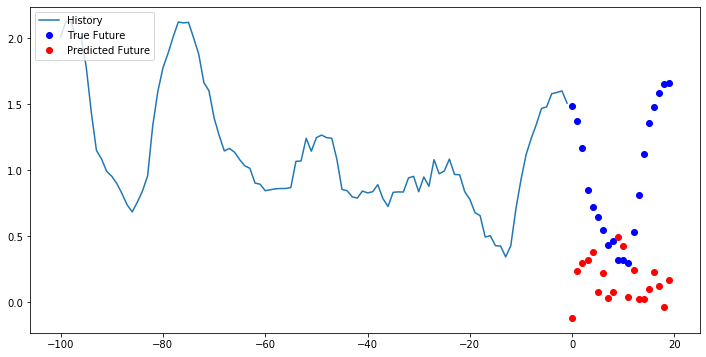

random_example_index =  7476


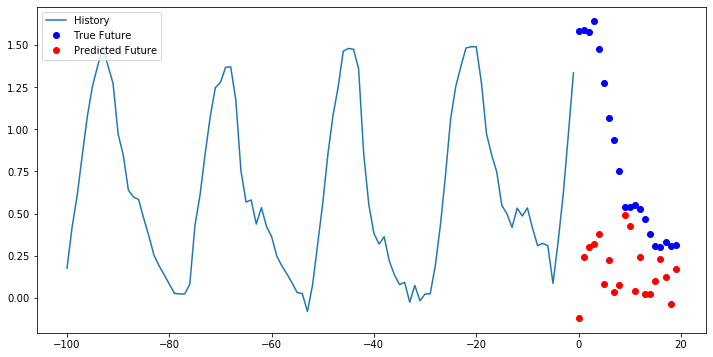

random_example_index =  20224


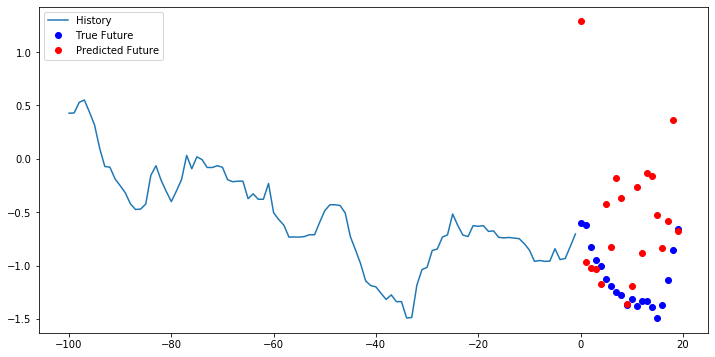

random_example_index =  12611


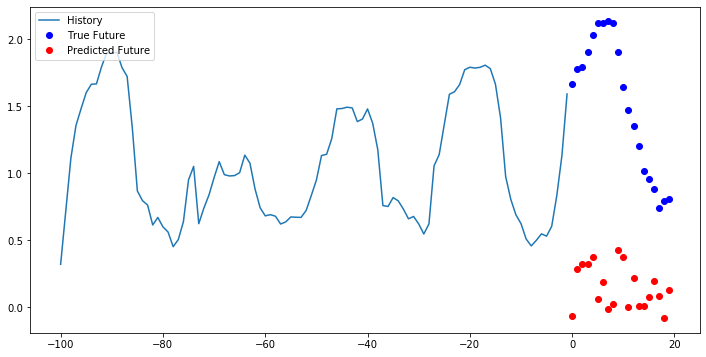

random_example_index =  15492


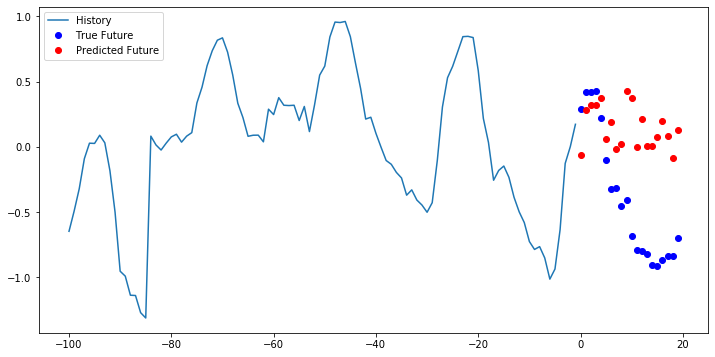

random_example_index =  18092


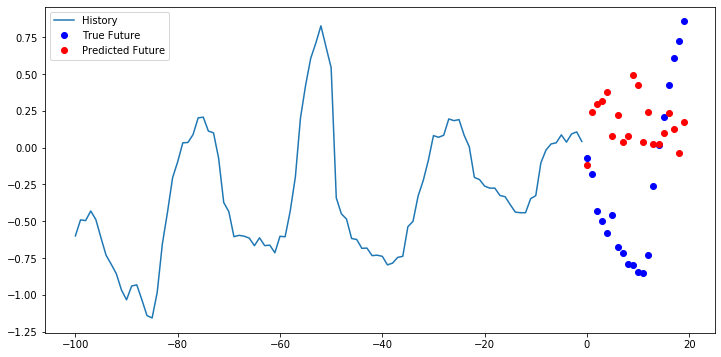

random_example_index =  22524


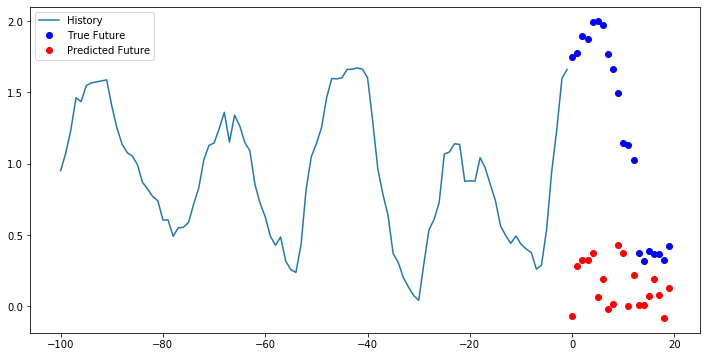

random_example_index =  23694


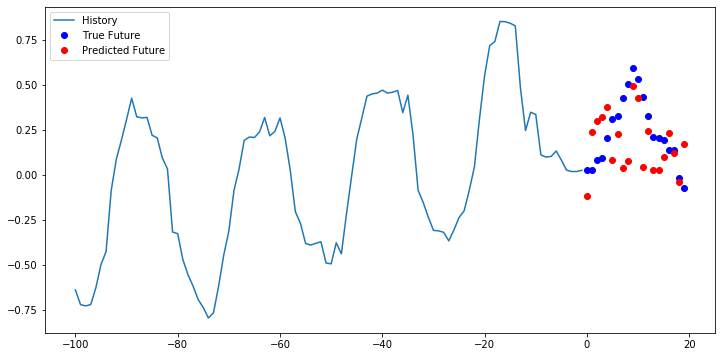

random_example_index =  7059


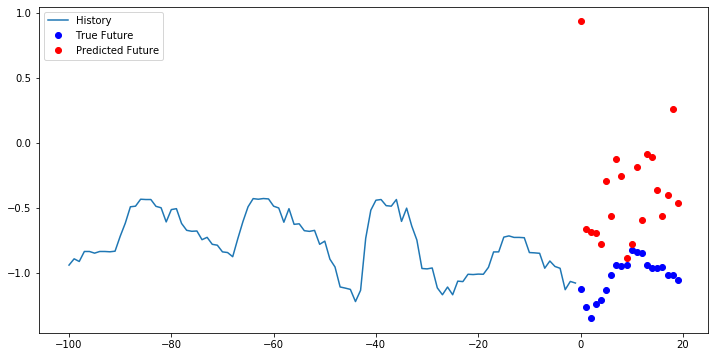

random_example_index =  7692


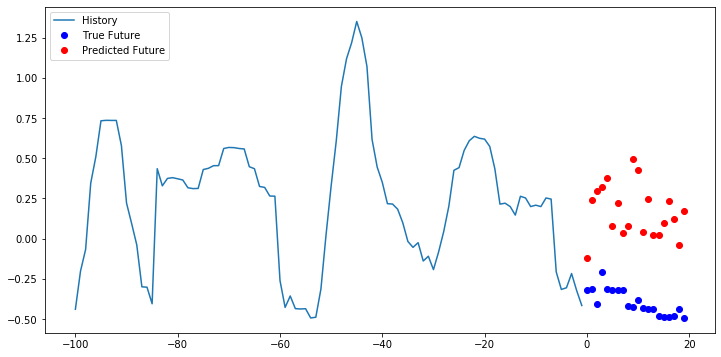

random_example_index =  19682


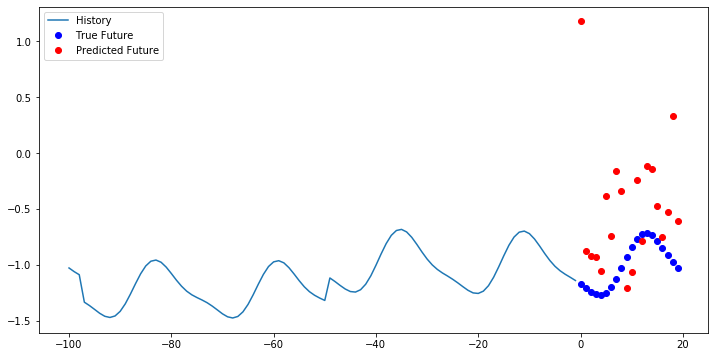

random_example_index =  25403


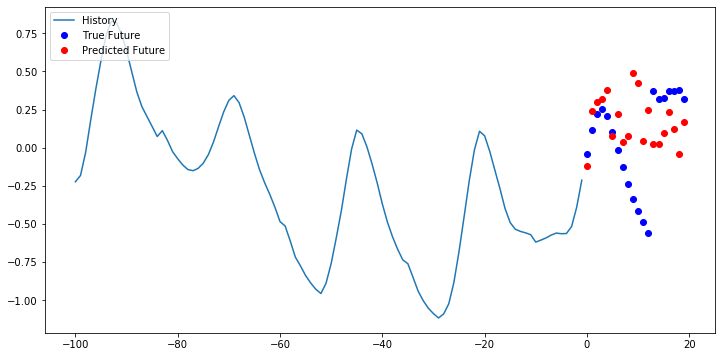

In [122]:
### Making some predictions on the testing data ###

mpl.rcParams['figure.figsize'] = (12, 8)

num_plots = 20
for i in range(num_plots):
    random_example_index = random.randint(0, x_test_mv.shape[0] - history_steps - future_steps)
    print('random_example_index = ', random_example_index)
    pred = model_mv2.predict(x_test_mv[random_example_index:random_example_index+1])
    pred = np.reshape(pred, (future_steps))
    
    multi_step_plot(history = x_test_mv[random_example_index], 
                    true_future = y_test_mv[random_example_index], 
                    prediction = pred)

In [63]:
### Building the model ###
def build_model(num_units_LSTM = [], num_units_Dense = [], input_shape = (), lr = 0.001, decay = 1e-5, loss = 'mae'):

    model = Sequential()
    
    return_sequences = (len(num_units_LSTM) != 1)
    model.add(LSTM(units = num_units_LSTM[0], input_shape = input_shape, activation = 'relu', return_sequences = return_sequences))
    
    for units in num_units_LSTM[1:-1]:
        model.add(LSTM(units = units, activation = 'relu', return_sequences = True))
    
    if len(num_units_LSTM) > 1:
        model.add(LSTM(units = num_units_LSTM[-1], activation = 'relu', return_sequences = False))
    
    for units in num_units_Dense[:-1]:
        model.add(Dense(units = units, activation = 'relu'))
        
    model.add(Dense(units = num_units_Dense[-1], activation = 'linear'))
        
    opt = Adam(lr = lr, decay = decay)
    model.compile(optimizer = opt, loss = loss)
    model.summary()
    
    return model

In [64]:
### Train the model ###
def train_model(model, x, y, x_val, y_val, batch_size, num_epochs):

    history = model.fit(x = x, 
                        y = y,
                        epochs = num_epochs,
                        batch_size = batch_size,
                        validation_data = (x_val, y_val))
    
    return history

In [65]:
### Plotting predictions ###
def plot_predictions(model, x, y, history_steps, future_steps, num_plots = 4):

    mpl.rcParams['figure.figsize'] = (12, 8)

    for i in range(num_plots):
        random_example_index = random.randint(0, x.shape[0] - history_steps - future_steps)
        print('random_example_index = ', random_example_index)
        pred = model.predict(x[random_example_index:random_example_index+1])
        pred = np.reshape(pred, (future_steps))

        multi_step_plot(history = x[random_example_index], 
                        true_future = y[random_example_index], 
                        prediction = pred)
    
    return

In [66]:
### Plotting the training loss ###
def plot_loss(history, remove_initial = 0):
    plt.figure(figsize=(10, 7))
#    mpl.rcParams['figure.figsize'] = (10, 7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    if remove_initial:
        loss = loss[remove_initial:]
        val_loss = val_loss[remove_initial:]
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.title('loss')
    plt.show()

In [91]:
num_units_LSTM = [64, 32, 16, 8]
num_units_Dense = [future_steps]
input_shape = (x_train_mv.shape[1:])
lr = 0.0001
decay = 1e-6
loss_lst = ['mae']
batch_size = 64
num_epochs = 60

# Already have some trained models (i=0 is the best one so far)
#models = []
#results = []

for i in range(1):

    model = build_model(num_units_LSTM = num_units_LSTM, 
                        num_units_Dense = num_units_Dense, 
                        input_shape = input_shape, 
                        lr = lr, 
                        decay = decay, 
                        loss = loss)
    history = train_model(model = model, 
                          x = x_train_mv, 
                          y = y_train_mv, 
                          x_val = x_test_mv, 
                          y_val = y_test_mv, 
                          batch_size = batch_size, 
                          num_epochs = num_epochs)
    print(type(model))
    models.append(model)
    results.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 100, 64)           17664     
_________________________________________________________________
lstm_56 (LSTM)               (None, 100, 32)           12416     
_________________________________________________________________
lstm_57 (LSTM)               (None, 100, 16)           3136      
_________________________________________________________________
lstm_58 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                180       
Total params: 34,196
Trainable params: 34,196
Non-trainable params: 0
_________________________________________________________________
Train on 69901 samples, validate on 26333 samples
Epoch 1/60
69901/69901 [==============================] - 680s 10ms/sample - loss: 0.924

ResourceExhaustedError: OOM when allocating tensor with shape[64,100,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node lstm_55/transpose_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Model number 0


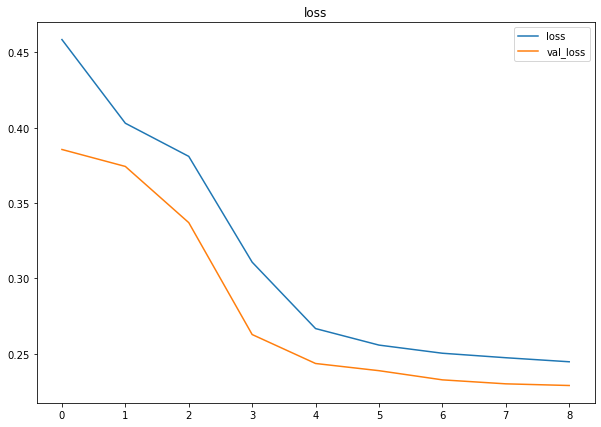

------------------------------------------------------
------------------------------------------------------
------------------------------------------------------
Model number 1


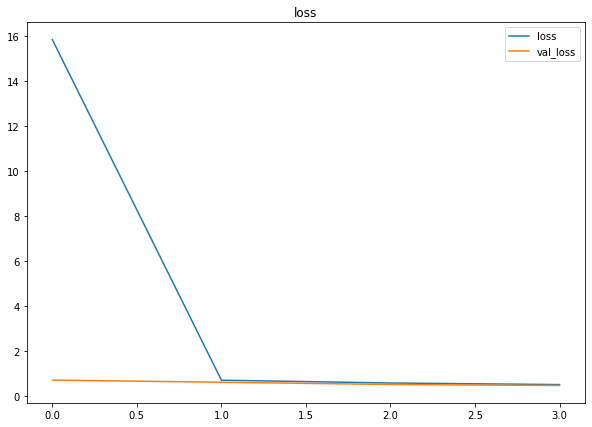

------------------------------------------------------
------------------------------------------------------
------------------------------------------------------
Model number 2


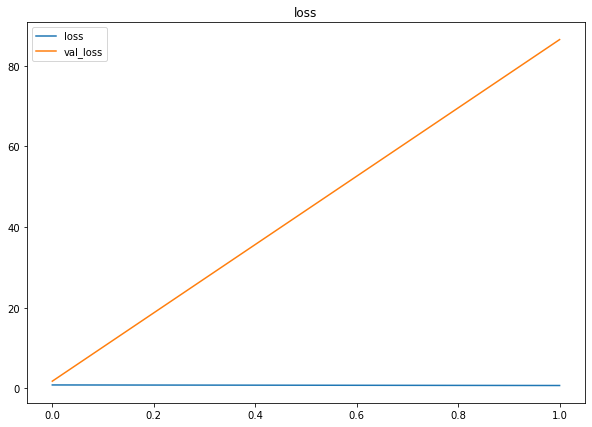

------------------------------------------------------
------------------------------------------------------
------------------------------------------------------
Model number 3


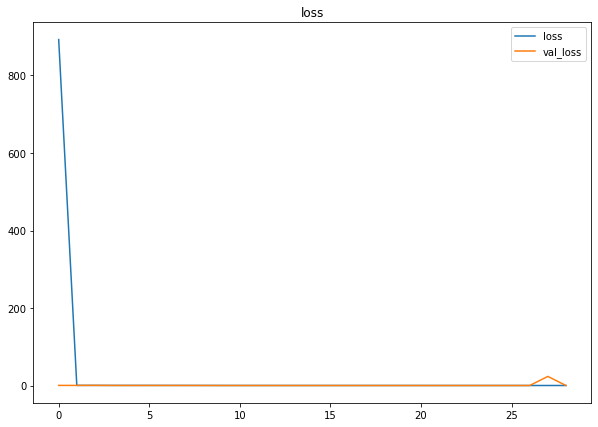

------------------------------------------------------
------------------------------------------------------
------------------------------------------------------


In [92]:
for i, history in enumerate(results):
    print('Model number {}'.format(i))
    plot_loss(history, remove_initial = 1)
    print('------------------------------------------------------')
    print('------------------------------------------------------')
    print('------------------------------------------------------')

Model number 0
random_example_index =  22335


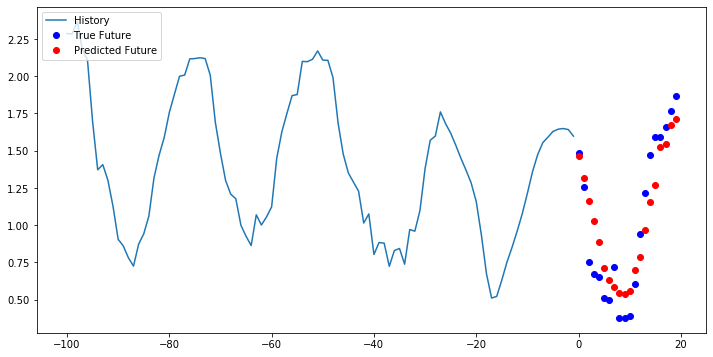

random_example_index =  35770


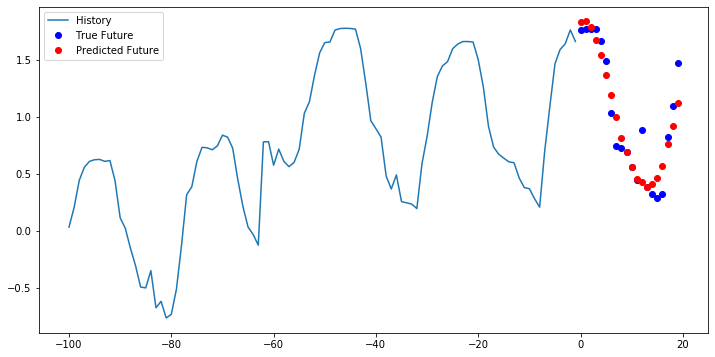

random_example_index =  48688


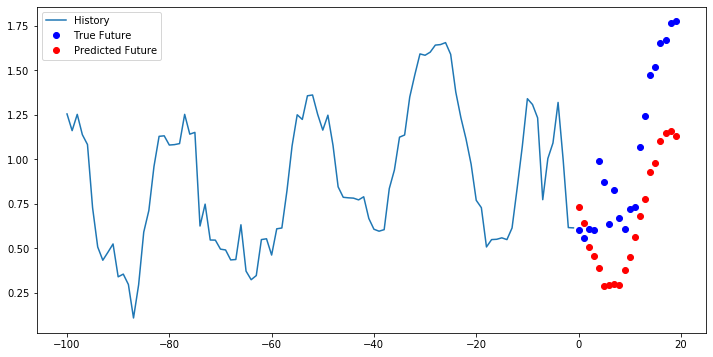

random_example_index =  62196


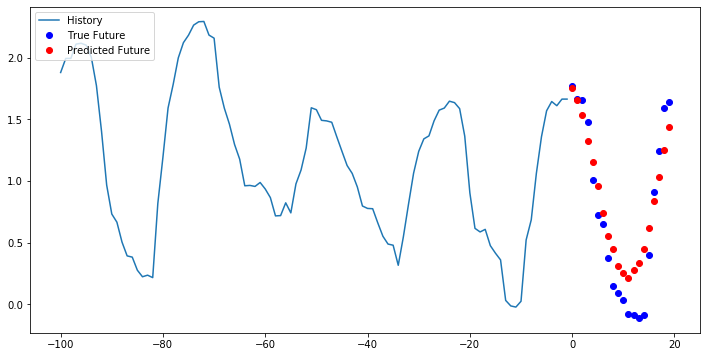

random_example_index =  5142


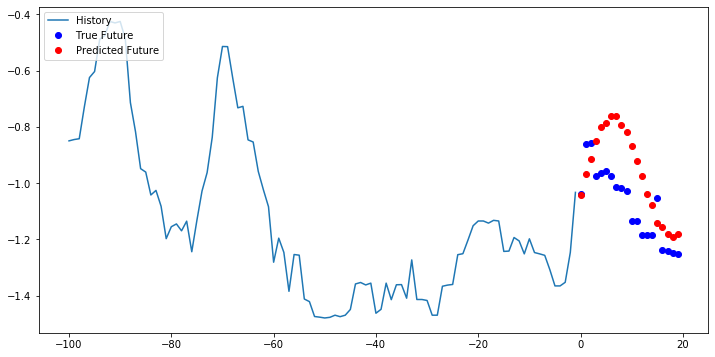

random_example_index =  21873


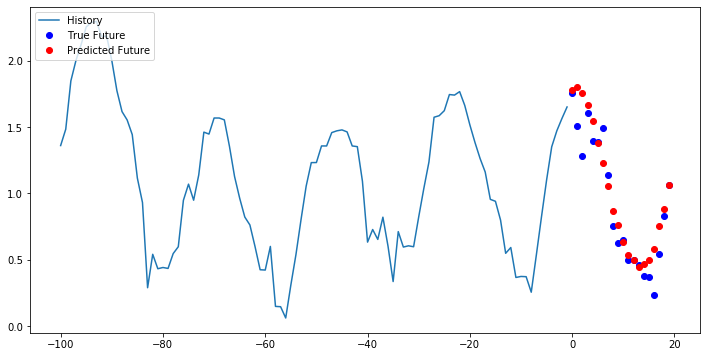

random_example_index =  61042


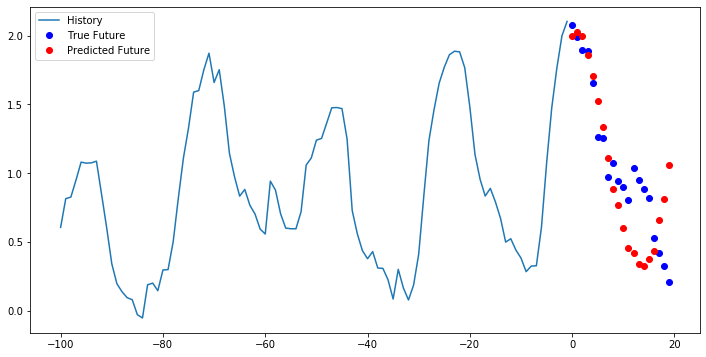

random_example_index =  44712


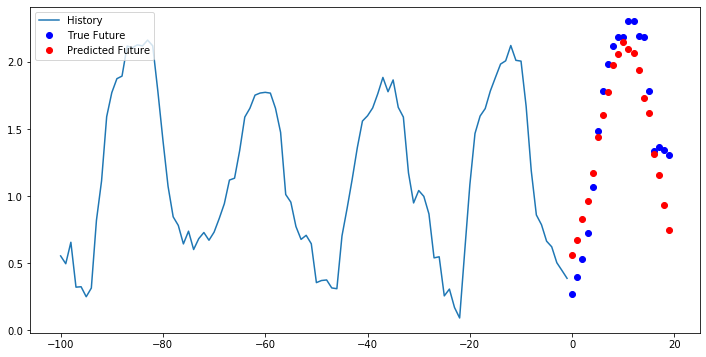

random_example_index =  54124


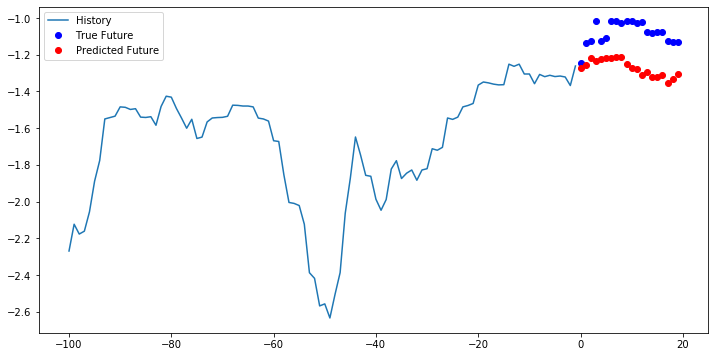

random_example_index =  48019


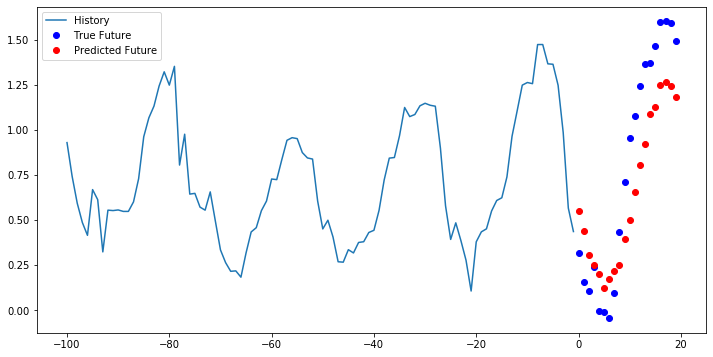

random_example_index =  69214


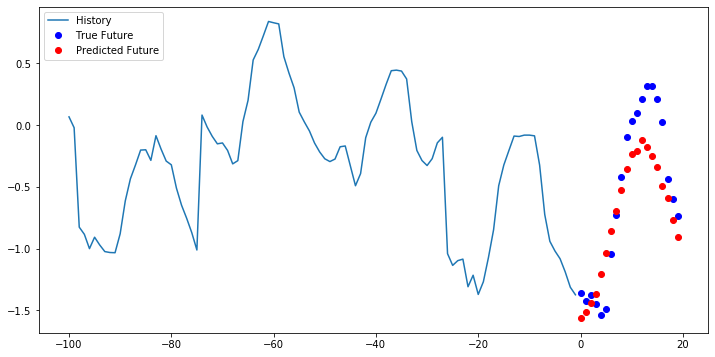

random_example_index =  55159


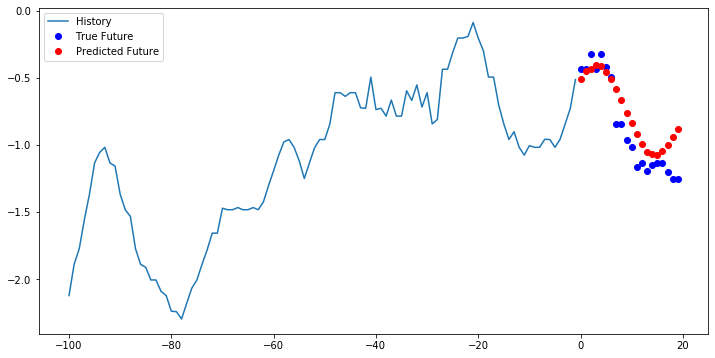

random_example_index =  16996


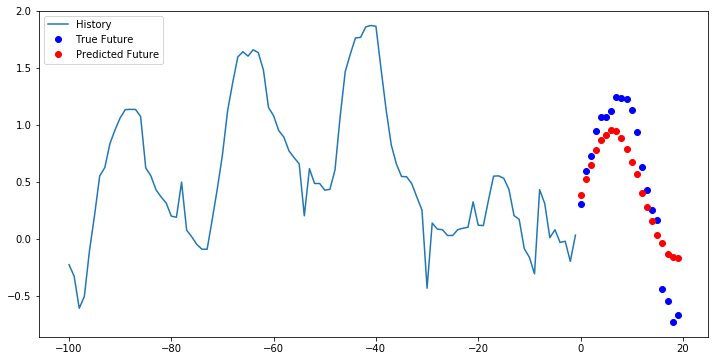

random_example_index =  68106


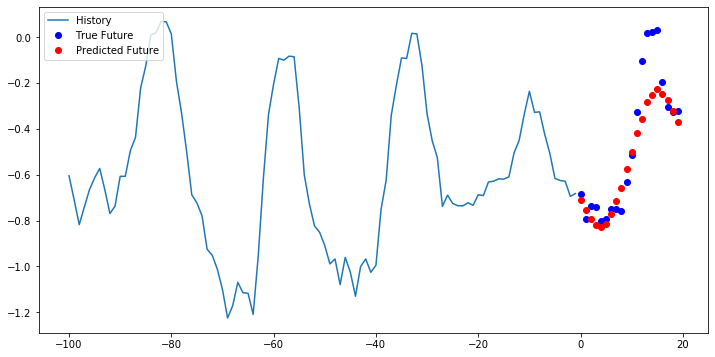

random_example_index =  46197


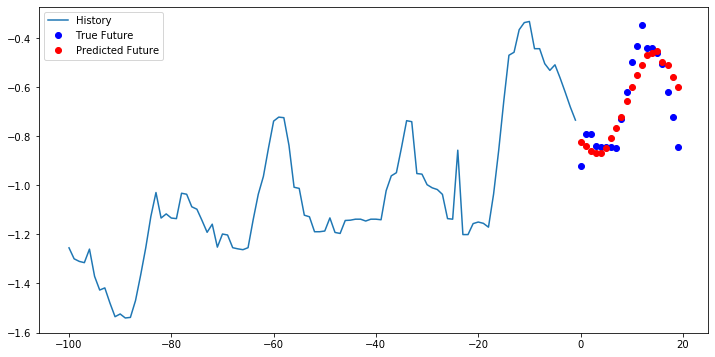

random_example_index =  51354


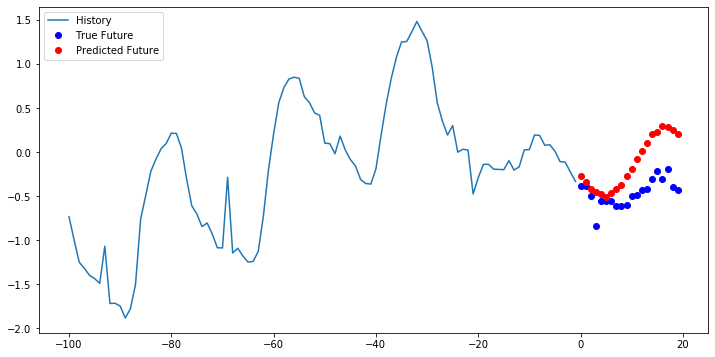

------------------------------------------------------
------------------------------------------------------
------------------------------------------------------


In [93]:
### Making predictions on the training data ###
for i, model in enumerate(models[-1:]):
    print('Model number {}'.format(i))
    plot_predictions(model = model, 
                     x = x_train_mv, 
                     y = y_train_mv,
                     history_steps = history_steps, 
                     future_steps = future_steps, 
                     num_plots = 16)
    print('------------------------------------------------------')
    print('------------------------------------------------------')
    print('------------------------------------------------------')


Model number 0
random_example_index =  11802


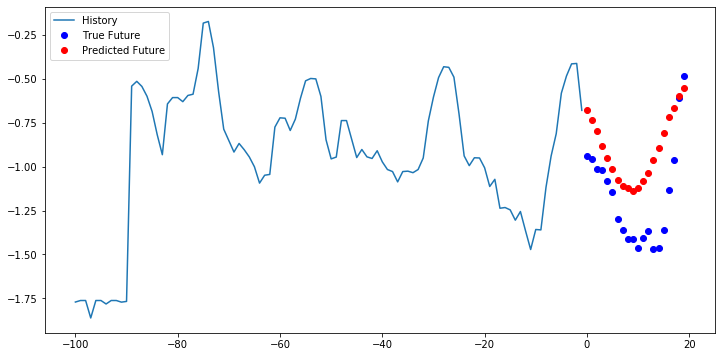

random_example_index =  18761


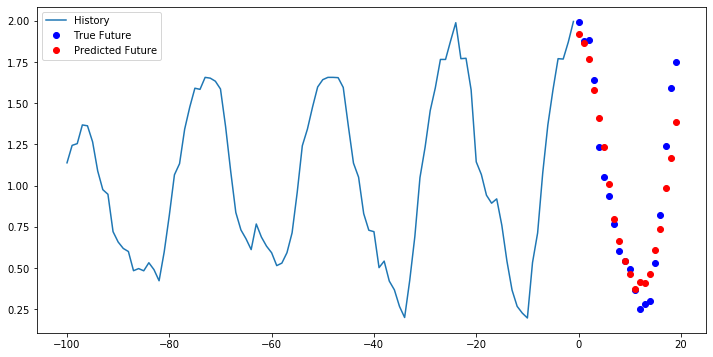

random_example_index =  4591


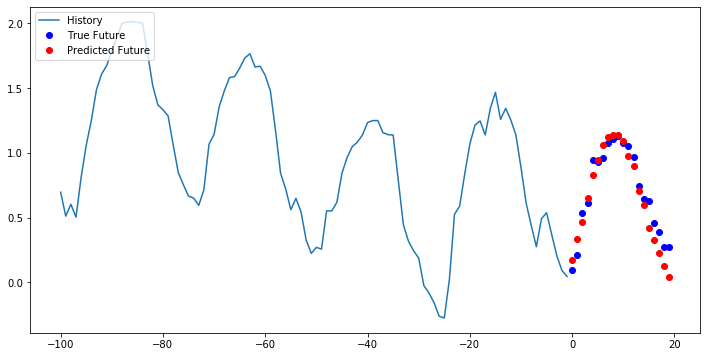

random_example_index =  1104


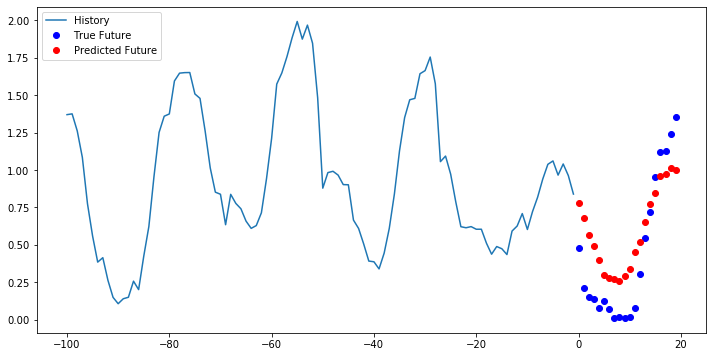

random_example_index =  10744


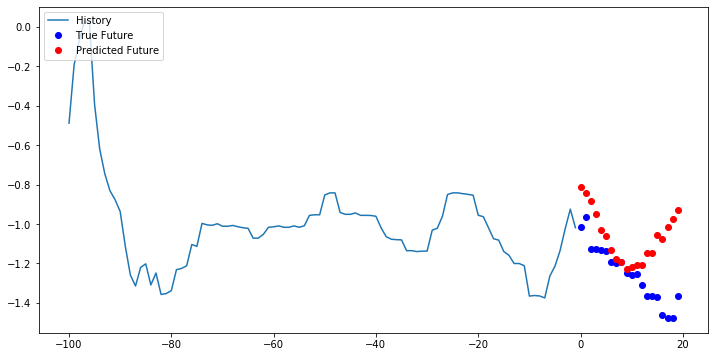

random_example_index =  19494


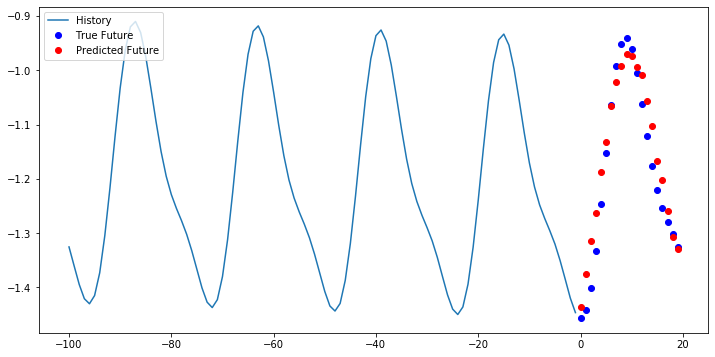

random_example_index =  9937


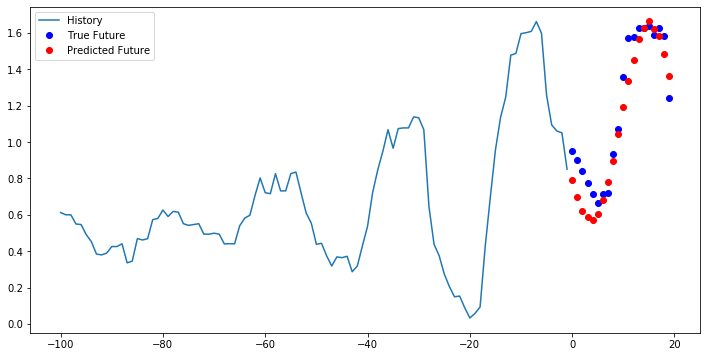

random_example_index =  4769


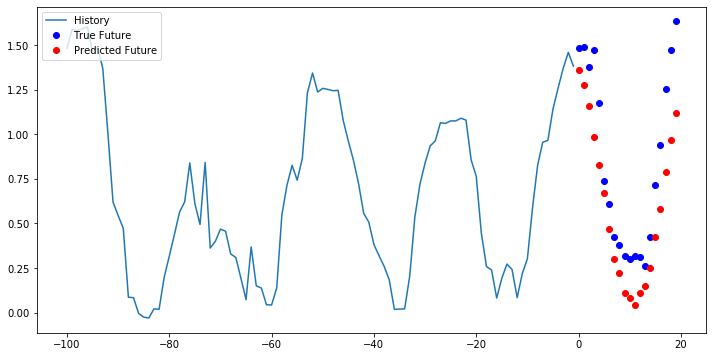

random_example_index =  4763


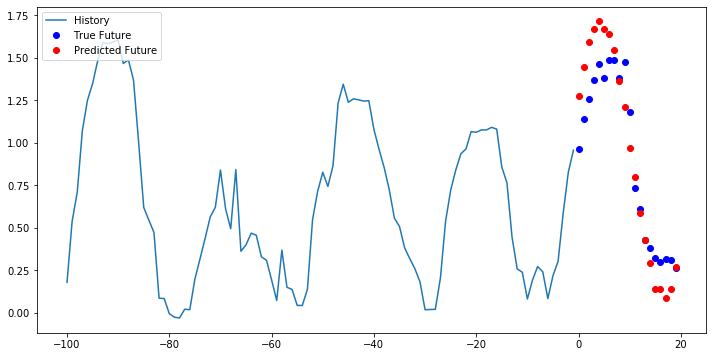

random_example_index =  10891


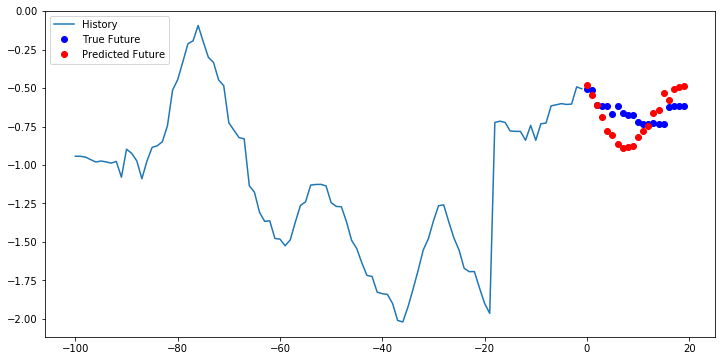

random_example_index =  1893


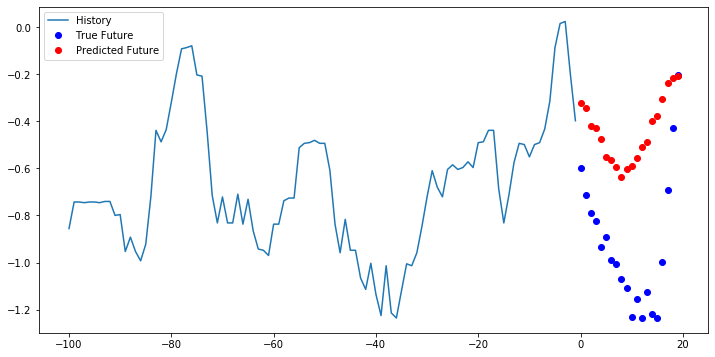

random_example_index =  3868


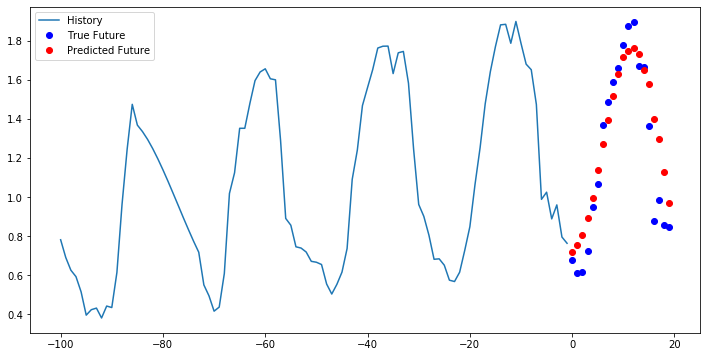

random_example_index =  15549


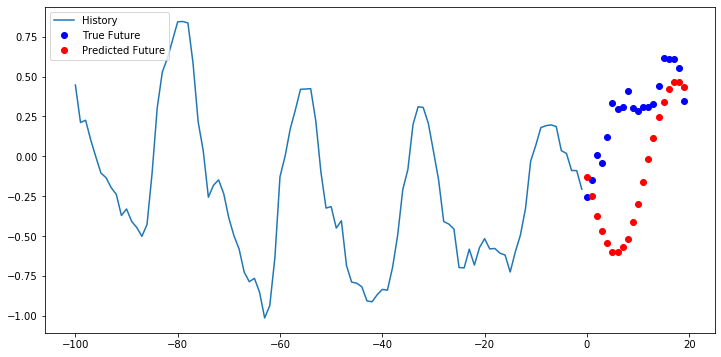

random_example_index =  11220


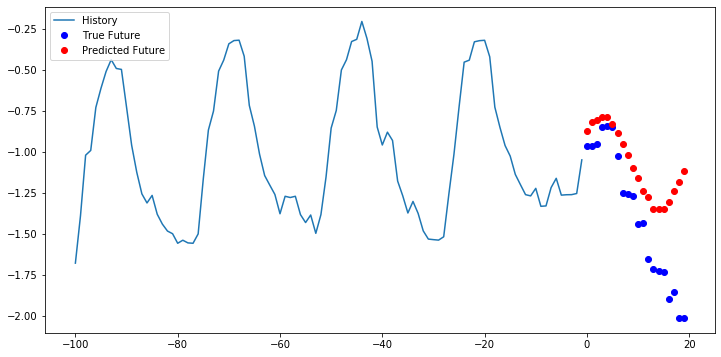

random_example_index =  21903


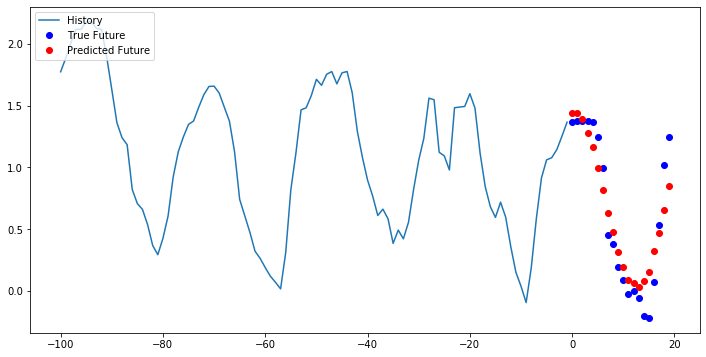

random_example_index =  4898


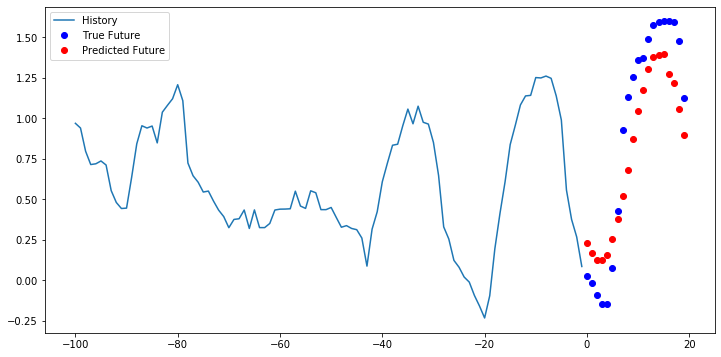

------------------------------------------------------
------------------------------------------------------
------------------------------------------------------


In [89]:
### Making predictions on the testing data ###
for i, model in enumerate(models[-1:]):
    print('Model number {}'.format(i))
    plot_predictions(model = model, 
                     x = x_test_mv, 
                     y = y_test_mv,
                     history_steps = history_steps, 
                     future_steps = future_steps, 
                     num_plots = 16)
    print('------------------------------------------------------')
    print('------------------------------------------------------')
    print('------------------------------------------------------')
